## Used to create plots perform analysis of output produced by model based on dose variations
- Output data will be saved as files and then imported here to analyse/plot.

In [1]:
import numpy as np
import numpy.polynomial.polynomial as poly
from scipy.optimize import curve_fit
import scipy as sp
import matplotlib.pyplot as plt
%matplotlib inline

import pickle

#import pandas as pd

mystyle = r'https://gist.githubusercontent.com/mbolt01/3087dffd11e70eccb08fdcf327374a5c/raw/std_fig'
plt.style.use(mystyle)

## can do my modelling in this notebook too.
import TCP_NTCP as model

In [23]:
import importlib
importlib.reload(model)

<module 'TCP_NTCP' from 'C:\\Users\\Matt\\OneDrive\\PhD\\Quasar Shared\\Documents\\Thesis\\Corrections\\Code\\Thesis_code_corrections\\TCP_NTCP.py'>

In [2]:
## functions to simply save and load files for use aftger producing modelling results

def save_pkl(obj,filename):
    pickle.dump(obj,open(filename,'wb'))

def load_pkl(filename):
    return pickle.load(open(filename,'rb'))

## example save:
#save_pkl(prost_10year,'test3.pkl')
## example load:
#newtest = load_pkl('test3.pkl')


## define colours and markers to use for each type
color_p = 'C0'
color_fc = 'C1'
color_hn = 'C2'

marker_p = 'o'
marker_fc = 's'
marker_hn = '^'

# Variation in doses
- Convolution of the different sources of dose variation.
    - Variation assumed to be normally distributed with standard deviations of:
        - Beam calibration: % (SD from NPL data) 
        - Output offset: % (variaiton in mean dose observed over a 2 month period for all meachines)
        - Daily variations: % (mean SD based on each machines farmer data)
- Convolution of normal distributions means just adding together the variances = SD^2
    - Total SD = sqrt(SD1^2 + SD2^2 + ...SDn^2)
    - https://en.wikipedia.org/wiki/Sum_of_normally_distributed_random_variables#Independent_random_variables
    - http://mathworld.wolfram.com/NormalSumDistribution.html

In [ ]:
## NPL MV data
## From the NPL Data the SD of the MV beam outputs is 0.7% (section 3.2.1)

## Systematic beam output
## From the first 7 weeks of output data this gives 0.7% also (section 4.3.7.2)

## Daily output fluctuations
## From the farmer chamber 0.2% (section 4.3.8)

npl_err = 0.7
op_err = 0.7
rand_err = 0.2

## convolute the erros together to give combined SDs
print('NPL only SD: ',npl_err)
npl_conv_op = np.sqrt(npl_err**2 + op_err**2)
print('NPL + Output SD: ',npl_conv_op)
npl_conv_op_conv_rand = np.sqrt(npl_err**2 + op_err**2 + rand_err**2)
print('NPL + Output + random SD: ',npl_conv_op_conv_rand)

print('--')
## produce 95% CI
print('NPL only 95%CI: ',npl_err*1.96)
print('NPL + Output 95%CI: ',npl_conv_op*1.96)
print('NPL + Output + random 95%CI: ',npl_conv_op_conv_rand*1.96)

## values to use:
print('--')
print('NPL only 95%CI use: ',1.4)
print('NPL + Output 95%CI use: ',1.9)
print('NPL + Output + random 95%CI use: ',2)

# Varied dose SD, fixed other parameters for a population
- Used to assess change in number of patients with a particular probability of getting a TCP outcome.
- From MALTHUS: extrapolate to 2015 for prostate and H&N.
    - Prostate: No. RT patients: 26486
    - H&N: No. RT patients: 8044
- From other simulations in thesis: a/b's = 2 (100 SD), 10 (25 SD) which were fitted to clinical data

In [51]:
results_p = model.completeTCPcalc(n=1,                  # number of patients in population to model
                                          alphabeta_use=2,      # mean alpha/beta
                                          alphabeta_sd_use=0,     # SD of alpha/beta (%)
                                          d=2,                    # nominal dose (Gy/fraction)
                                          d_shift=my_d_shift,          # initial dose difference (%)
                                          d_sd=0,                 # standard deviation of delivered dose (%)
                                          d_trend=0,              # dose drift (%/day)
                                          max_d=100,              # maximum dose for which TCP is calcualted (Gy)
                                          dose_of_interest=74,    # results of TCP at this dose are returned seperately for simpler analysis.
                                          n0 = 1E4,
                                         set_beta=0.04)
results_p

{'TCP_cure_percent': 97.119022339719791,
 'TCP_input': None,
 'TCP_pop': array([  0.000e+000,   0.000e+000,   0.000e+000,   0.000e+000,
          0.000e+000,   0.000e+000,   0.000e+000,   6.379e-277,
          1.886e-196,   1.999e-139,   5.145e-099,   2.230e-070,
          4.381e-050,   1.053e-035,   1.634e-025,   2.723e-018,
          3.570e-013,   1.511e-009,   5.613e-007,   3.719e-005,
          7.261e-004,   5.964e-003,   2.653e-002,   7.637e-002,
          1.616e-001,   2.748e-001,   4.004e-001,   5.228e-001,
          6.315e-001,   7.220e-001,   7.939e-001,   8.491e-001,
          8.905e-001,   9.211e-001,   9.434e-001,   9.596e-001,
          9.712e-001,   9.795e-001,   9.854e-001,   9.897e-001,
          9.927e-001,   9.948e-001,   9.963e-001,   9.974e-001,
          9.981e-001,   9.987e-001,   9.991e-001,   9.993e-001,
          9.995e-001,   9.997e-001]),
 'TCPs': array([[  0.000e+000,   0.000e+000,   0.000e+000,   0.000e+000,
           0.000e+000,   0.000e+000,   0.000e+000

In [109]:
## model a fixed population (fixed set of a/b ratios) with systematic shifts in dose.
## record the mean and also number >20%,80%, 90% etc.
## this would be like the same set of patients being treated on different linacs

n_p = 26318 #26318 fro malthus
n_hn = 8093 #8093 from malthus

## creates array of [alpha,beta values] - (model can now return this more directly)
ab_p = model.create_alpha_beta_array(n_p,2,100*100/2) 
ab_hn = model.create_alpha_beta_array(n_hn,10,100*25/10)

## create list of a/b values
ab_ratios_p = [i[0]/i[1] for i in ab_p]
ab_ratios_hn = [i[0]/i[1] for i in ab_hn]

my_d_shifts = [-5,-4,-3,-2,-1,0,1,2,3,4,5] ## different dose shifts to test
all_res_p = {}
all_res_hn = {}
for my_d_shift in my_d_shifts:
    
    
    tcps_p = []
    tcps_hn = []
    
    ## prostate
    for i in range(n_p):
        results_p = model.completeTCPcalc(n=1,                  # number of patients in population to model
                                          alphabeta_use=2,      # mean alpha/beta
                                          alphabeta_sd_use=100,     # SD of alpha/beta (%)
                                          d=2,                    # nominal dose (Gy/fraction)
                                          d_shift=my_d_shift,          # initial dose difference (%)
                                          d_sd=0,                 # standard deviation of delivered dose (%)
                                          d_trend=0,              # dose drift (%/day)
                                          max_d=100,              # maximum dose for which TCP is calcualted (Gy)
                                          dose_of_interest=74,    # results of TCP at this dose are returned seperately for simpler analysis.
                                          n0 = 1E4,
                                         set_beta=0.04)                # N0 as determnined through population fit
        tcps_p.append(results_p['TCP_cure_percent']) ## store the TCP value only
    
    ## head and neck
    for j in range(n_hn):
        results_hn = model.completeTCPcalc(n=1,                  # number of patients in population to model
                                          alphabeta_use=10,      # mean alpha/beta
                                          alphabeta_sd_use=25,     # SD of alpha/beta (%)
                                          d=65/30,                    # nominal dose (Gy/fraction)
                                          d_shift=my_d_shift,          # initial dose difference (%)
                                          d_sd=0,                 # standard deviation of delivered dose (%)
                                          d_trend=0,              # dose drift (%/day)
                                          max_d=100,              # maximum dose for which TCP is calcualted (Gy)
                                          dose_of_interest=65,    # results of TCP at this dose are returned seperately for simpler analysis.
                                          n0 = 1E6,
                                          set_beta=0.02)                # N0 as determnined through population fit
        tcps_hn.append(results_hn['TCP_cure_percent'])
    
    all_res_p[my_d_shift]=tcps_p ## store TCPs for each dose shift
    all_res_hn[my_d_shift]=tcps_hn

    print(my_d_shift,np.mean(all_res_p[my_d_shift]),np.mean(all_res_hn[my_d_shift]))

-5 46.0319548326 51.8855871888
-4 48.8150625477 54.9343684458
-3 49.6286065618 57.2089894637
-2 51.6081575745 59.4184872599
-1 54.0441544912 61.3942973612
0 56.0433510161 63.3800672282
1 57.5472899374 65.7426011989
2 59.8472913234 67.7250149168
3 61.5610823283 70.0670265065
4 63.8077495128 71.0285543837
5 65.5105305087 73.1409491167


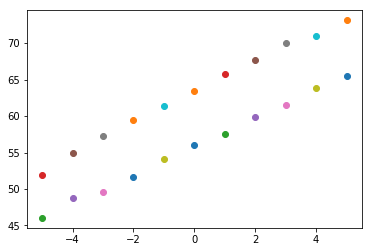

In [110]:
#save_pkl(all_res_p,'pop_results-p.pkl')
#save_pkl(all_res_hn,'pop_results-hn.pkl')
#all_res_p = load_pkl('pop_results-p.pkl')
#all_res_hn = load_pkl('pop_results-hn.pkl')
## example plot of population means of +/-5% dose shift
for i in all_res_p:
    plt.plot(i,np.mean(all_res_p[i],axis=0),'o')
    plt.plot(i,np.mean(all_res_hn[i],axis=0),'o')

In [113]:
## code from here deleted in error!

## want to produce the number of <10% and >90% for both cases.

for j in sorted(all_res_p): ## loop each dose shift
    lt10_p = len([i for i in all_res_p[j] if i <10])
    gt90_p = len([i for i in all_res_p[j] if i >90])
    lt10_hn = len([i for i in all_res_hn[j] if i <10])
    gt90_hn = len([i for i in all_res_hn[j] if i >90])
    print(j,lt10_p,gt90_p,lt10_hn,gt90_hn)
                  

-5 10021 7811 2410 2460
-4 9125 8356 2156 2661
-3 8858 8411 2023 2884
-2 8108 8780 1841 3041
-1 7425 9353 1683 3210
0 6801 9729 1552 3397
1 6353 10032 1364 3563
2 5694 10421 1243 3757
3 5165 10792 1150 3981
4 4548 11407 1082 4091
5 3962 11651 912 4252


In [ ]:
## prost = [36]
## hn = [29]
## a single curve is all_res_p[dose_shift][i] ## i is the ith patient

## get mean, number above 90%, below 10%
## prost
## get only values at dose of interest
#all_res_hn[0][0][36]
dose_shift=0

tcps0=tcps = [data[0][i][29] for i in range(len(data[0]))]
tcps2=tcps = [data[2][i][29] for i in range(len(data[2]))]
tcps_2=tcps = [data[-2][i][29] for i in range(len(data[-2]))]
colors = ['C0','C2','C1']
all_data = [tcps_2,tcps0,tcps2]
labels = ['-2%','0%','+2%']

fig, ax = plt.subplots(nrows=3,sharex=True,figsize=(6,5),sharey=True)

j=0
for plotdata in all_data:
    ax[j].hist(plotdata,bins=20,range=(0,1),color=colors[j],label=labels[j])
    ax[j].axvline(0.2,ls=':',lw=1,color='black')
    ax[j].axvline(0.8,ls=':',lw=1,color='black')
    ax[j].axvspan(0.2,0.8,color='white',alpha=0.5)
    ax[j].legend(loc='upper center')
    j=j+1
    
#plt.xlim(-0.1,1.1)
#plt.legend(title='Systematic dose shift',loc='upper center')
ax[1].set_ylabel('Number of patients')
plt.xlabel('Calculated TCP')
plt.suptitle(title)
#plt.savefig('population tcp change with dose shift-3plots.png',dpi=300,bbox_inches='tight')
plt.show()

# Fixed dose/# with % dose shift (e.g. cal dif or output difference)
- Do for H&N and both prostate cases.
- Store the results for each run in dict (and save)
- Can then compare TCP at given dose and see spread or plot different shifts etc.
- Do a run where dose shifta are drawn from a normal dist (NPL + output convolution)
    - This will show variations for a single patient depended on where treated

In [ ]:
## new version with 3 clinical cases

## prostate

## dict to store results

do_this = True
if do_this == True:
    res_p = {}

    ## dose shifts to apply (same for each fraciton as no SD)
    d_shifts = np.arange(-5,5,0.25)
    print('dose shifts: ',d_shifts)

    for the_d in d_shifts:
        results = model.completeTCPcalc(n=1,                  # number of patients in population to model
                                      alphabeta_use=2,      # mean alpha/beta
                                      alphabeta_sd_use=0,     # SD of alpha/beta (%)
                                      d=2,                    # nominal dose (Gy/fraction)
                                      d_shift=the_d,          # initial dose difference (%)
                                      d_sd=0,                 # standard deviation of delivered dose (%)
                                      d_trend=0,              # dose drift (%/day)
                                      max_d=100,              # maximum dose for which TCP is calcualted (Gy)
                                      dose_of_interest=74,    # results of TCP at this dose are returned seperately for simpler analysis.
                                      n0 = 5E4,
                                      set_beta=0.04)                # N0 as determnined through population fit
        res_p[the_d] = results

    print('RT01 done')
    
    res_fc = {}

    for the_d in d_shifts:
        results = model.completeTCPcalc(n=1,                  # number of patients in population to model
                                      alphabeta_use=2,      # mean alpha/beta
                                      alphabeta_sd_use=0,     # SD of alpha/beta (%)
                                      d=2,                    # nominal dose (Gy/fraction)
                                      d_shift=the_d,          # initial dose difference (%)
                                      d_sd=0,                 # standard deviation of delivered dose (%)
                                      d_trend=0,              # dose drift (%/day)
                                      max_d=100,              # maximum dose for which TCP is calcualted (Gy)
                                      dose_of_interest=76,    # results of TCP at this dose are returned seperately for simpler analysis.
                                      n0 = 9E4,
                                      set_beta=0.04)                # N0 as determnined through population fit
        res_fc[the_d] = results

    print('Fox chase done')

    ## H&N 
    ## dict to store results
    res_hn = {}

    for the_d in d_shifts:
        results = model.completeTCPcalc(n=1,                  # number of patients in population to model
                                      alphabeta_use=10,      # mean alpha/beta
                                      alphabeta_sd_use=0,     # SD of alpha/beta (%)
                                      d=65/30,                    # nominal dose (Gy/fraction)
                                      d_shift=the_d,          # initial dose difference (%)
                                      d_sd=0,                 # standard deviation of delivered dose (%)
                                      d_trend=0,              # dose drift (%/day)
                                      max_d=100,              # maximum dose for which TCP is calcualted (Gy)
                                      dose_of_interest=65,    # results of TCP at this dose are returned seperately for simpler analysis.
                                      n0 = 3E6,
                                      set_beta=0.02)                # N0 as determnined through population fit
        res_hn[the_d] = results

    print('H&N done')

In [ ]:
## plot the calcualted TCP (in percentage) against the dose shift (%)

tcp_percs_p = []
orig_tcp_p = res_p[0]['TCP_cure_percent']
tcp_percs_fc = []
orig_tcp_fc = res_fc[0]['TCP_cure_percent']
tcp_percs_hn = []
orig_tcp_hn = res_hn[0]['TCP_cure_percent']

## get the dose shifts from the saved data
d_shifts = [i for i in sorted(res_p.keys())]

for i in d_shifts:
    ## rt01
    the_tcp_p = res_p[i]['TCP_cure_percent'] ## TCP at the specified dose of interest
    tcp_perc_dif_p = ((the_tcp_p/orig_tcp_p)-1)*100
    tcp_percs_p.append(tcp_perc_dif_p)
    ## fox chase
    the_tcp_fc = res_fc[i]['TCP_cure_percent'] ## TCP at the specified dose of interest
    tcp_perc_dif_fc = ((the_tcp_fc/orig_tcp_fc)-1)*100
    tcp_percs_fc.append(tcp_perc_dif_fc)
    ## hn
    the_tcp_hn = res_hn[i]['TCP_cure_percent'] ## TCP at the specified dose of interest
    tcp_perc_dif_hn = ((the_tcp_hn/orig_tcp_hn)-1)*100
    tcp_percs_hn.append(tcp_perc_dif_hn)
    print('shift:',i,'p',tcp_perc_dif_p,'hn',tcp_perc_dif_hn)
    
plt.plot(d_shifts,tcp_percs_p,ls='',marker=marker_p,ms=3,label='Prostate: RT01',color=color_p)
plt.plot(d_shifts,tcp_percs_fc,ls='',marker=marker_fc,ms=3,label='Prostate: Fox Chase',color=color_fc)
plt.plot(d_shifts,tcp_percs_hn,ls='',marker=marker_hn,ms=3,label='Head & neck: PARSPORT',color=color_hn)
plt.title('Variation in calculated TCP with dose variation: \nIndividual Patients')
plt.ylabel('TCP change (%)')
plt.xlabel('Dose shift (%)')

plt.axhline(0,color='black',lw=0.5,zorder=0)
plt.axvline(0,color='black',lw=0.5,zorder=0)

#plt.ylim(-40,40)

## add a polynomial...
## do the polynomial fit and create function from it

add_fit = False
if add_fit == True:
    for i in [tcp_percs_p,tcp_percs_hn]:
        coefs = poly.polyfit(d_shifts, i, 2)
        ffit = poly.Polynomial(coefs)
        if i == tcp_percs_p:
            fit_color = color=color_p
        else:
            fit_color = color=color_hn
        ## generate some x values and then plot the curve at these points
        x_fit = np.linspace(start=min(d_shifts),stop=max(d_shifts),num=100,endpoint=True)

        plt.plot(x_fit, ffit(x_fit),color=fit_color,lw=1,zorder=0)
    
## shade the regions of interest with different colours and labels
output_errors = {1.4:{'label':'Calibration \nuncertainty (95% CI)',
                    'color':'#a5a5a5'},
                 1.9:{'label':'Cal + output \nuncertainty (95% CI)',
                   'color':'#cccccc'},
                2:{'label':'Cal + output + fluctuations \nuncertainty (95% CI)',
                   'color':'#dfdfdf'}}

for val in sorted(output_errors,reverse=True):
    plt.axvspan(-val,val,alpha=1,color=output_errors[val]['color'],zorder=0,label=output_errors[val]['label'])

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

#plt.savefig('variation with dose shift-shade-corr.png',dpi=300,bbox_inches='tight')
plt.show()

In [ ]:
## get the numerical data in a nicer format to view

print('shift\trt01\tfc\th&n')
for i in range(len(d_shifts)):
    
    print(d_shifts[i],
          '\t',round(tcp_percs_p[i],1),
         '\t',round(tcp_percs_fc[i],1),
         '\t',round(tcp_percs_hn[i],1),)

In [ ]:
## repeat above for ****population**** of patients and look at change in population TCP values
## this will be smaller change than for individual patients modelled above.
## now includes a/b SD

## new version with 3 clinical cases

## prostate

## dict to store results

do_this = True
if do_this == True:
    res_p = {}

    ## dose shifts to apply (same for each fraciton as no SD)
    d_shifts = np.arange(-5,5,0.25)
    print('dose shifts: ',d_shifts)

    for the_d in d_shifts:
        results = model.completeTCPcalc(n=10000,                  # number of patients in population to model
                                      alphabeta_use=2,      # mean alpha/beta
                                      alphabeta_sd_use=100,     # SD of alpha/beta (%)
                                      d=2,                    # nominal dose (Gy/fraction)
                                      d_shift=the_d,          # initial dose difference (%)
                                      d_sd=0,                 # standard deviation of delivered dose (%)
                                      d_trend=0,              # dose drift (%/day)
                                      max_d=100,              # maximum dose for which TCP is calcualted (Gy)
                                      dose_of_interest=74,    # results of TCP at this dose are returned seperately for simpler analysis.
                                      n0 = 1E4,
                                      set_beta=0.04)                # N0 as determnined through population fit
        res_p[the_d] = results

    print('RT01 done')
    
    res_fc = {}

    for the_d in d_shifts:
        results = model.completeTCPcalc(n=10000,                  # number of patients in population to model
                                      alphabeta_use=2,      # mean alpha/beta
                                      alphabeta_sd_use=5,     # SD of alpha/beta (%)
                                      d=2,                    # nominal dose (Gy/fraction)
                                      d_shift=the_d,          # initial dose difference (%)
                                      d_sd=0,                 # standard deviation of delivered dose (%)
                                      d_trend=0,              # dose drift (%/day)
                                      max_d=100,              # maximum dose for which TCP is calcualted (Gy)
                                      dose_of_interest=76,    # results of TCP at this dose are returned seperately for simpler analysis.
                                      n0 = 5E4,
                                      set_beta=0.04)                # N0 as determnined through population fit
        res_fc[the_d] = results

    print('Fox chase done')

    ## H&N 
    ## dict to store results
    res_hn = {}

    for the_d in d_shifts:
        results = model.completeTCPcalc(n=10000,                  # number of patients in population to model
                                      alphabeta_use=10,      # mean alpha/beta
                                      alphabeta_sd_use=25,     # SD of alpha/beta (%)
                                      d=65/30,                    # nominal dose (Gy/fraction)
                                      d_shift=the_d,          # initial dose difference (%)
                                      d_sd=0,                 # standard deviation of delivered dose (%)
                                      d_trend=0,              # dose drift (%/day)
                                      max_d=100,              # maximum dose for which TCP is calcualted (Gy)
                                      dose_of_interest=65,    # results of TCP at this dose are returned seperately for simpler analysis.
                                      n0 = 1E6,
                                      set_beta=0.02)                # N0 as determnined through population fit
        res_hn[the_d] = results

    print('H&N done')

In [ ]:
## plot the calcualted TCP (in percentage) against the dose shift (%)

#### *** population model results

tcp_percs_p = []
orig_tcp_p = res_p[0]['TCP_cure_percent']
tcp_percs_fc = []
orig_tcp_fc = res_fc[0]['TCP_cure_percent']
tcp_percs_hn = []
orig_tcp_hn = res_hn[0]['TCP_cure_percent']

## get the dose shifts from the saved data
d_shifts = [i for i in sorted(res_p.keys())]

for i in d_shifts:
    ## rt01
    the_tcp_p = res_p[i]['TCP_cure_percent'] ## TCP at the specified dose of interest
    tcp_perc_dif_p = ((the_tcp_p/orig_tcp_p)-1)*100
    tcp_percs_p.append(tcp_perc_dif_p)
    ## fox chase
    the_tcp_fc = res_fc[i]['TCP_cure_percent'] ## TCP at the specified dose of interest
    tcp_perc_dif_fc = ((the_tcp_fc/orig_tcp_fc)-1)*100
    tcp_percs_fc.append(tcp_perc_dif_fc)
    ## hn
    the_tcp_hn = res_hn[i]['TCP_cure_percent'] ## TCP at the specified dose of interest
    tcp_perc_dif_hn = ((the_tcp_hn/orig_tcp_hn)-1)*100
    tcp_percs_hn.append(tcp_perc_dif_hn)
    print('shift:',i,'p',tcp_perc_dif_p,'fc',tcp_perc_dif_fc,'hn',tcp_perc_dif_hn)
    
plt.plot(d_shifts,tcp_percs_p,ls='',marker=marker_p,ms=3,label='Prostate: RT01',color=color_p)
plt.plot(d_shifts,tcp_percs_fc,ls='',marker=marker_fc,ms=3,label='Prostate: Fox Chase',color=color_fc)
plt.plot(d_shifts,tcp_percs_hn,ls='',marker=marker_hn,ms=3,label='Head & neck: PARSPORT',color=color_hn)
plt.title('Variation in calculated population TCP with dose variation: \nPopulation of 1000 patients')
plt.ylabel('TCP change (%)')
plt.xlabel('Dose shift (%)')

plt.axhline(0,color='black',lw=0.5,zorder=0)
plt.axvline(0,color='black',lw=0.5,zorder=0)

#plt.ylim(-40,40)

## add a polynomial...
## do the polynomial fit and create function from it

add_fit = False
if add_fit == True:
    for i in [tcp_percs_p,tcp_percs_hn]:
        coefs = poly.polyfit(d_shifts, i, 2)
        ffit = poly.Polynomial(coefs)
        if i == tcp_percs_p:
            fit_color = color=color_p
        else:
            fit_color = color=color_hn
        ## generate some x values and then plot the curve at these points
        x_fit = np.linspace(start=min(d_shifts),stop=max(d_shifts),num=100,endpoint=True)

        plt.plot(x_fit, ffit(x_fit),color=fit_color,lw=1,zorder=0)
    
## shade the regions of interest with different colours and labels
output_errors = {1.4:{'label':'Calibration \nuncertainty (95% CI)',
                    'color':'#a5a5a5'},
                 1.9:{'label':'Cal + output \nuncertainty (95% CI)',
                   'color':'#cccccc'},
                2:{'label':'Cal + output + fluctuations \nuncertainty (95% CI)',
                   'color':'#dfdfdf'}}

for val in sorted(output_errors,reverse=True):
    plt.axvspan(-val,val,alpha=1,color=output_errors[val]['color'],zorder=0,label=output_errors[val]['label'])

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

#plt.savefig('variation with dose shift-shade-corr-pop.png',dpi=300,bbox_inches='tight')
plt.show()

In [ ]:
## get the numerical data in a nicer format to view

print('shift\trt01\tfc\th&n')
for i in range(len(d_shifts)):
    
    print(d_shifts[i],
          '\t',round(tcp_percs_p[i],1),
         '\t',round(tcp_percs_fc[i],1),
         '\t',round(tcp_percs_hn[i],1),)

In [ ]:
## prostate

## dict to store results

do_this = True
if do_this == True:
    res_p = {}

    ## dose shifts to apply (same for each fraciton as no SD)
    d_shifts = np.arange(-5,5,0.25)
    print('dose shifts: ',d_shifts)

    for the_d in d_shifts:
        results = model.completeTCPcalc(n=1,                  # number of patients in population to model
                                      alphabeta_use=1.5,      # mean alpha/beta
                                      alphabeta_sd_use=0,     # SD of alpha/beta (%)
                                      d=2,                    # nominal dose (Gy/fraction)
                                      d_shift=the_d,          # initial dose difference (%)
                                      d_sd=0,                 # standard deviation of delivered dose (%)
                                      d_trend=0,              # dose drift (%/day)
                                      max_d=100,              # maximum dose for which TCP is calcualted (Gy)
                                      dose_of_interest=74,    # results of TCP at this dose are returned seperately for simpler analysis.
                                      n0 = 74)                # N0 as determnined through population fit
        res_p[the_d] = results

    print('Prostate done')

    ## H&N 
    ## dict to store results
    res_hn = {}

    for the_d in d_shifts:
        results = model.completeTCPcalc(n=1,                  # number of patients in population to model
                                      alphabeta_use=10,      # mean alpha/beta
                                      alphabeta_sd_use=0,     # SD of alpha/beta (%)
                                      d=65/30,                    # nominal dose (Gy/fraction)
                                      d_shift=the_d,          # initial dose difference (%)
                                      d_sd=0,                 # standard deviation of delivered dose (%)
                                      d_trend=0,              # dose drift (%/day)
                                      max_d=100,              # maximum dose for which TCP is calcualted (Gy)
                                      dose_of_interest=65,    # results of TCP at this dose are returned seperately for simpler analysis.
                                      n0 = 3000000)                # N0 as determnined through population fit
        res_hn[the_d] = results

    print('H&N done')


In [ ]:
plt.plot(res_hn[0]['nom_doses'],res_hn[0]['TCP_pop'])
plt.plot(65,0.66,'o')
plt.show()

In [ ]:
## Save/Load data

# save:
#save_pkl(res_p,'prost_d_shift_var.pkl')
#save_pkl(res_hn,'hn_d_shift_var.pkl')

## load:
res_p = load_pkl('prost_d_shift_var.pkl')
res_hn = load_pkl('hn_d_shift_var.pkl')

In [ ]:
## plot the calcualted TCP (in percentage) against the dose shift (%)

tcp_percs_p = []
orig_tcp_p = res_p[0]['TCP_cure_percent']
tcp_percs_hn = []
orig_tcp_hn = res_hn[0]['TCP_cure_percent']

## get the dose shifts from the saved data
d_shifts = [i for i in res_p.keys()]

for i in d_shifts:
    ## prost
    the_tcp_p = res_p[i]['TCP_cure_percent'] ## TCP at the specified dose of interest
    tcp_perc_dif_p = ((the_tcp_p/orig_tcp_p)-1)*100
    tcp_percs_p.append(tcp_perc_dif_p)
    ## hn
    the_tcp_hn = res_hn[i]['TCP_cure_percent'] ## TCP at the specified dose of interest
    tcp_perc_dif_hn = ((the_tcp_hn/orig_tcp_hn)-1)*100
    tcp_percs_hn.append(tcp_perc_dif_hn)
    print('shift:',i,'p',tcp_perc_dif_p,'hn',tcp_perc_dif_hn)
    
plt.plot(d_shifts,tcp_percs_p,'o',ms=3,label='Prostate',color=color_p)
plt.plot(d_shifts,tcp_percs_hn,'o',ms=3,label='Head & neck',color=color_hn)
plt.title('Variation in calculated TCP with dose variation')
plt.ylabel('TCP change (%)')
plt.xlabel('Dose shift (%)')

plt.axhline(0,color='black',lw=0.5,zorder=0)
plt.axvline(0,color='black',lw=0.5,zorder=0)

#plt.ylim(-40,40)

## add a polynomial...
## do the polynomial fit and create function from it

add_fit = False
if add_fit == True:
    for i in [tcp_percs_p,tcp_percs_hn]:
        coefs = poly.polyfit(d_shifts, i, 2)
        ffit = poly.Polynomial(coefs)
        if i == tcp_percs_p:
            fit_color = color=color_p
        else:
            fit_color = color=color_hn
        ## generate some x values and then plot the curve at these points
        x_fit = np.linspace(start=min(d_shifts),stop=max(d_shifts),num=100,endpoint=True)

        plt.plot(x_fit, ffit(x_fit),color=fit_color,lw=1,zorder=0)
    
## shade the regions of interest with different colours and labels
output_errors = {1.4:{'label':'Calibration \nuncertainty (95% CI)',
                    'color':'#a5a5a5'},
                 1.9:{'label':'Cal + output \nuncertainty (95% CI)',
                   'color':'#cccccc'},
                2:{'label':'Cal + output + fluctuations \nuncertainty (95% CI)',
                   'color':'#dfdfdf'}}

for val in sorted(output_errors,reverse=True):
    plt.axvspan(-val,val,alpha=1,color=output_errors[val]['color'],zorder=0,label=output_errors[val]['label'])

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

#plt.savefig('variation with dose shift-shade2.png',dpi=300,bbox_inches='tight')
plt.show()

# Include dose drift from initial value of 0%.
- Range between +/-5% drift/year.
    - Treatment length is ~6 weeks, so max of +/-0.6%/treatment
    
- Add shading for 95% CI of drifts/year.

In [5]:
## prostate

## dict to store results

do_this = True
if do_this == True:
    res_p = {}

    ## dose drifts to apply (same for each fraction as no SD)
    d_drifts = np.arange(-10,10,0.5)
    print('dose drifts: ',d_drifts)

    for the_d in d_drifts:
        results = model.completeTCPcalc(n=1,                  # number of patients in population to model
                                      alphabeta_use=2,      # mean alpha/beta
                                      alphabeta_sd_use=0,     # SD of alpha/beta (%)
                                      d=2,                    # nominal dose (Gy/fraction)
                                      d_shift=0,          # initial dose difference (%)
                                      d_sd=0,                 # standard deviation of delivered dose (%)
                                      d_trend=the_d/365,              # dose drift (%/day)
                                      max_d=100,              # maximum dose for which TCP is calcualted (Gy)
                                      dose_of_interest=74,    # results of TCP at this dose are returned seperately for simpler analysis.
                                      n0 = 5E4,
                                      set_beta=0.04)                # N0 as determnined through population fit
        res_p[the_d] = results

    print('RT01 done')
    
    ## Fox chase 
    res_fc={}
    
    for the_d in d_drifts:
        results = model.completeTCPcalc(n=1,                  # number of patients in population to model
                                      alphabeta_use=2,      # mean alpha/beta
                                      alphabeta_sd_use=0,     # SD of alpha/beta (%)
                                      d=2,                    # nominal dose (Gy/fraction)
                                      d_shift=0,          # initial dose difference (%)
                                      d_sd=0,                 # standard deviation of delivered dose (%)
                                      d_trend=the_d/365,              # dose drift (%/day)
                                      max_d=100,              # maximum dose for which TCP is calcualted (Gy)
                                      dose_of_interest=76,    # results of TCP at this dose are returned seperately for simpler analysis.
                                      n0 = 9E4,
                                      set_beta=0.04)                # N0 as determnined through population fit
        res_fc[the_d] = results

    print('Fox Chase done')

    ## H&N 
    ## dict to store results
    res_hn = {}

    for the_d in d_drifts:
        results = model.completeTCPcalc(n=1,                  # number of patients in population to model
                                      alphabeta_use=10,      # mean alpha/beta
                                      alphabeta_sd_use=0,     # SD of alpha/beta (%)
                                      d=65/30,                    # nominal dose (Gy/fraction)
                                      d_shift=0,          # initial dose difference (%)
                                      d_sd=0,                 # standard deviation of delivered dose (%)
                                      d_trend=the_d/365,              # dose drift (%/day)
                                      max_d=100,              # maximum dose for which TCP is calcualted (Gy)
                                      dose_of_interest=65,    # results of TCP at this dose are returned seperately for simpler analysis.
                                      n0 = 3E6,
                                      set_beta=0.02)                # N0 as determnined through population fit
        res_hn[the_d] = results

    print('H&N done')


dose drifts:  [-10.   -9.5  -9.   -8.5  -8.   -7.5  -7.   -6.5  -6.   -5.5  -5.   -4.5
  -4.   -3.5  -3.   -2.5  -2.   -1.5  -1.   -0.5   0.    0.5   1.    1.5
   2.    2.5   3.    3.5   4.    4.5   5.    5.5   6.    6.5   7.    7.5
   8.    8.5   9.    9.5]
RT01 done
Fox Chase done
H&N done


In [36]:
## Save/Load data

# save:
#save_pkl(res_p,'prost_d_drift_var-pop.pkl')
#save_pkl(res_hn,'hn_d_drift_var-pop.pkl')
#save_pkl(res_fc,'fc_d_drift_var-pop.pkl')

## load:
#res_p = load_pkl('prost_d_drift_var.pkl')
#res_hn = load_pkl('hn_d_drift_var.pkl')

KeyboardInterrupt: 

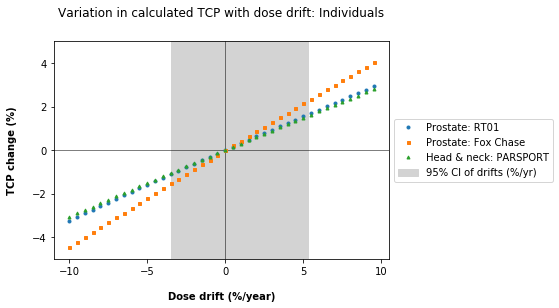

In [22]:
## plot the calcualted TCP (in percentage) against the dose drift (%/yr)

tcp_percs_p = []
orig_tcp_p = res_p[0]['TCP_cure_percent']
tcp_percs_fc = []
orig_tcp_fc = res_fc[0]['TCP_cure_percent']
tcp_percs_hn = []
orig_tcp_hn = res_hn[0]['TCP_cure_percent']

## get the dose drifts from the saved data
d_drifts = [i for i in res_p.keys()]

for i in d_drifts:
    ## prost rt01
    the_tcp_p = res_p[i]['TCP_cure_percent'] ## TCP at the specified dose of interest
    tcp_perc_dif_p = ((the_tcp_p/orig_tcp_p)-1)*100
    tcp_percs_p.append(tcp_perc_dif_p)
    ## prost fox chase
    the_tcp_fc = res_fc[i]['TCP_cure_percent'] ## TCP at the specified dose of interest
    tcp_perc_dif_fc = ((the_tcp_fc/orig_tcp_fc)-1)*100
    tcp_percs_fc.append(tcp_perc_dif_fc)
    ## hn
    the_tcp_hn = res_hn[i]['TCP_cure_percent'] ## TCP at the specified dose of interest
    tcp_perc_dif_hn = ((the_tcp_hn/orig_tcp_hn)-1)*100
    tcp_percs_hn.append(tcp_perc_dif_hn)
    
plt.plot(d_drifts,tcp_percs_p,marker=marker_p,ms=3,label='Prostate: RT01',color=color_p,ls='')
plt.plot(d_drifts,tcp_percs_fc,marker=marker_fc,ms=3,label='Prostate: Fox Chase',color=color_fc,ls='')
plt.plot(d_drifts,tcp_percs_hn,marker=marker_hn,ms=3,label='Head & neck: PARSPORT',color=color_hn,ls='')
plt.title('Variation in calculated TCP with dose drift: Individuals')
plt.ylabel('TCP change (%)')
plt.xlabel('Dose drift (%/year)')

plt.axhline(0,color='black',lw=0.5,zorder=0)
plt.axvline(0,color='black',lw=0.5,zorder=0)

#plt.ylim(-40,40)

## add a polynomial...
## do the polynomial fit and create function from it

add_fit = False
if add_fit == True:
    for i in [tcp_percs_p,tcp_percs_fc,tcp_percs_hn]:
        coefs = poly.polyfit(d_drifts, i, 1)
        ffit = poly.Polynomial(coefs)
        if i == tcp_percs_p:
            fit_color = color_p
        elif i == tcp_percs_fc:
            fit_color = color_fc
        else:
            fit_color = color_hn
        ## generate some x values and then plot the curve at these points
        x_fit = np.linspace(start=min(d_drifts),stop=max(d_drifts),num=100,endpoint=True)

        plt.plot(x_fit, ffit(x_fit),color=fit_color,lw=0.5,zorder=0)
    
## shade the regions of interest with different colours and labels
plt.axvspan(-3.5,5.3,alpha=1,color='lightgrey',zorder=0,label='95% CI of drifts (%/yr)')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xticks([-10,-5,0,5,10])
plt.ylim(-5,5)

#plt.savefig('variation with dose drift-shade.png',dpi=300,bbox_inches='tight')
plt.show()

In [32]:
## as above for population **WILL OVERWRITE RESULTS OF ABOVE**

## prostate

## dict to store results

pop_size=10000
print('n:',pop_size)

do_this = True
if do_this == True:
    res_p_ = {}

    ## dose drifts to apply (same for each fraction as no SD)
    d_drifts = np.arange(-10,10,0.5)
    print('dose drifts: ',d_drifts)

    for the_d in d_drifts:
        print(the_d)
        results = model.completeTCPcalc(n=pop_size,                  # number of patients in population to model
                                      alphabeta_use=2,      # mean alpha/beta
                                      alphabeta_sd_use=100,     # SD of alpha/beta (%)
                                      d=2,                    # nominal dose (Gy/fraction)
                                      d_shift=0,          # initial dose difference (%)
                                      d_sd=0,                 # standard deviation of delivered dose (%)
                                      d_trend=the_d/365,              # dose drift (%/day)
                                      max_d=100,              # maximum dose for which TCP is calcualted (Gy)
                                      dose_of_interest=74,    # results of TCP at this dose are returned seperately for simpler analysis.
                                      n0 = 1E4,
                                      set_beta=0.04)                # N0 as determnined through population fit
        res_p[the_d] = results

    print('RT01 done')
    
    ## Fox chase 
    res_fc={}
    
    for the_d in d_drifts:
        print(the_d)
        results = model.completeTCPcalc(n=pop_size,                  # number of patients in population to model
                                      alphabeta_use=2,      # mean alpha/beta
                                      alphabeta_sd_use=5,     # SD of alpha/beta (%)
                                      d=2,                    # nominal dose (Gy/fraction)
                                      d_shift=0,          # initial dose difference (%)
                                      d_sd=0,                 # standard deviation of delivered dose (%)
                                      d_trend=the_d/365,              # dose drift (%/day)
                                      max_d=100,              # maximum dose for which TCP is calcualted (Gy)
                                      dose_of_interest=76,    # results of TCP at this dose are returned seperately for simpler analysis.
                                      n0 = 5E4,
                                      set_beta=0.04)                # N0 as determnined through population fit
        res_fc[the_d] = results

    print('Fox Chase done')

    ## H&N 
    ## dict to store results
    res_hn = {}

    for the_d in d_drifts:
        print(the_d)
        results = model.completeTCPcalc(n=pop_size,                  # number of patients in population to model
                                      alphabeta_use=10,      # mean alpha/beta
                                      alphabeta_sd_use=25,     # SD of alpha/beta (%)
                                      d=65/30,                    # nominal dose (Gy/fraction)
                                      d_shift=0,          # initial dose difference (%)
                                      d_sd=0,                 # standard deviation of delivered dose (%)
                                      d_trend=the_d/365,              # dose drift (%/day)
                                      max_d=100,              # maximum dose for which TCP is calcualted (Gy)
                                      dose_of_interest=65,    # results of TCP at this dose are returned seperately for simpler analysis.
                                      n0 = 1E6,
                                      set_beta=0.02)                # N0 as determnined through population fit
        res_hn[the_d] = results

    print('H&N done')


n: 100000
dose drifts:  [-10.   -9.5  -9.   -8.5  -8.   -7.5  -7.   -6.5  -6.   -5.5  -5.   -4.5
  -4.   -3.5  -3.   -2.5  -2.   -1.5  -1.   -0.5   0.    0.5   1.    1.5
   2.    2.5   3.    3.5   4.    4.5   5.    5.5   6.    6.5   7.    7.5
   8.    8.5   9.    9.5]
-10.0
-9.5
-9.0
-8.5
-8.0
-7.5
-7.0
-6.5
-6.0
-5.5
-5.0
-4.5
-4.0
-3.5
-3.0
-2.5
-2.0
-1.5
-1.0
-0.5
0.0
0.5
1.0
1.5
2.0
2.5
3.0
3.5
4.0
4.5
5.0
5.5
6.0
6.5
7.0
7.5
8.0
8.5
9.0
9.5
RT01 done
-10.0
-9.5
-9.0
-8.5
-8.0
-7.5
-7.0
-6.5
-6.0
-5.5
-5.0
-4.5
-4.0
-3.5
-3.0
-2.5
-2.0
-1.5
-1.0
-0.5
0.0
0.5
1.0
1.5
2.0
2.5
3.0
3.5
4.0
4.5
5.0
5.5
6.0
6.5
7.0
7.5
8.0
8.5
9.0
9.5
Fox Chase done
-10.0
-9.5
-9.0
-8.5
-8.0
-7.5
-7.0
-6.5
-6.0
-5.5
-5.0
-4.5
-4.0
-3.5
-3.0
-2.5
-2.0
-1.5
-1.0
-0.5
0.0
0.5
1.0
1.5
2.0
2.5
3.0
3.5
4.0
4.5
5.0
5.5
6.0
6.5
7.0
7.5
8.0
8.5
9.0
9.5
H&N done


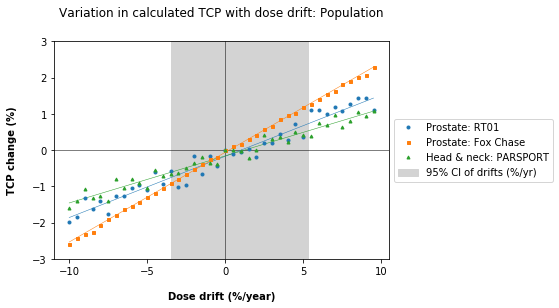

In [35]:
## plot the calcualted TCP (in percentage) against the dose drift (%/yr)

tcp_percs_p = []
orig_tcp_p = res_p[0]['TCP_cure_percent']
tcp_percs_fc = []
orig_tcp_fc = res_fc[0]['TCP_cure_percent']
tcp_percs_hn = []
orig_tcp_hn = res_hn[0]['TCP_cure_percent']

## get the dose drifts from the saved data
d_drifts = [i for i in res_p.keys()]

for i in d_drifts:
    ## prost rt01
    the_tcp_p = res_p[i]['TCP_cure_percent'] ## TCP at the specified dose of interest
    tcp_perc_dif_p = ((the_tcp_p/orig_tcp_p)-1)*100
    tcp_percs_p.append(tcp_perc_dif_p)
    ## prost fox chase
    the_tcp_fc = res_fc[i]['TCP_cure_percent'] ## TCP at the specified dose of interest
    tcp_perc_dif_fc = ((the_tcp_fc/orig_tcp_fc)-1)*100
    tcp_percs_fc.append(tcp_perc_dif_fc)
    ## hn
    the_tcp_hn = res_hn[i]['TCP_cure_percent'] ## TCP at the specified dose of interest
    tcp_perc_dif_hn = ((the_tcp_hn/orig_tcp_hn)-1)*100
    tcp_percs_hn.append(tcp_perc_dif_hn)
    
plt.plot(d_drifts,tcp_percs_p,marker=marker_p,ms=3,label='Prostate: RT01',color=color_p,ls='')
plt.plot(d_drifts,tcp_percs_fc,marker=marker_fc,ms=3,label='Prostate: Fox Chase',color=color_fc,ls='')
plt.plot(d_drifts,tcp_percs_hn,marker=marker_hn,ms=3,label='Head & neck: PARSPORT',color=color_hn,ls='')
plt.title('Variation in calculated TCP with dose drift: Population')
plt.ylabel('TCP change (%)')
plt.xlabel('Dose drift (%/year)')

plt.axhline(0,color='black',lw=0.5,zorder=0)
plt.axvline(0,color='black',lw=0.5,zorder=0)

#plt.ylim(-40,40)

## add a polynomial...
## do the polynomial fit and create function from it

add_fit = True
if add_fit == True:
    for i in [tcp_percs_p,tcp_percs_fc,tcp_percs_hn]:
        coefs = poly.polyfit(d_drifts, i, 1)
        ffit = poly.Polynomial(coefs)
        if i == tcp_percs_p:
            fit_color = color_p
        elif i == tcp_percs_fc:
            fit_color = color_fc
        else:
            fit_color = color_hn
        ## generate some x values and then plot the curve at these points
        x_fit = np.linspace(start=min(d_drifts),stop=max(d_drifts),num=100,endpoint=True)

        plt.plot(x_fit, ffit(x_fit),color=fit_color,lw=0.5,zorder=0)
    
## shade the regions of interest with different colours and labels
plt.axvspan(-3.5,5.3,alpha=1,color='lightgrey',zorder=0,label='95% CI of drifts (%/yr)')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xticks([-10,-5,0,5,10])
plt.ylim(-3,3)

#plt.savefig('variation with dose drift-shade-pop10k-fit.png',dpi=300,bbox_inches='tight')
plt.show()

# Effect of treatment of different machines
- Same patient treated on 100 different machines with random dose delivery based on range of bem outputs (+cals).
- Get dose from uniform dist with SD = 0.7% (NPL only) and 1.0% (NPL + beam output).
    - Shade the 95% CI based on these 2 sets of data.
    - Probably want seperate plots for prostate and H&N.
    
    - Or can do boxplots of TCP for each 

In [ ]:

##sds for normal distributions to use for NPL only and NPL + OPs
npl_sd = 0.7
npl_op_sd = 1.0

the_mean = 0 ## mean output
num = 1000 ## number of 'machines'

do_this = True
if do_this == True:
        
    ## generate output from normal distribution for both sets of SDs
    mean_ops_npl = np.random.normal(loc=the_mean,scale=npl_sd,size=num)
    mean_ops_npl_op = np.random.normal(loc=the_mean,scale=npl_op_sd,size=num)

    ## Prostate NPL only
    res_p_npl = []

    ## calc TCP and store for each factor (beam output)
    for the_d in mean_ops_npl:
        results = model.completeTCPcalc(n=1,                  # number of patients in population to model
                                      alphabeta_use=1.5,      # mean alpha/beta
                                      alphabeta_sd_use=0,     # SD of alpha/beta (%)
                                      d=2,                    # nominal dose (Gy/fraction)
                                      d_shift=the_d,          # initial dose difference (%)
                                      d_sd=0,                 # standard deviation of delivered dose (%)
                                      d_trend=0,              # dose drift (%/day)
                                      max_d=100,              # maximum dose for which TCP is calcualted (Gy)
                                      dose_of_interest=74,    # results of TCP at this dose are returned seperately for simpler analysis.
                                      n0 = 74)                # N0 as determnined through population fit
        ## save the TCP percentage to list
        res_p_npl.append(results['TCP_cure_percent'])

    print('Prostate NPL only done',np.std(res_p_npl))
    
    

    ## H&N  NPL only
    res_hn_npl = []

    for the_d in mean_ops_npl:
        results = model.completeTCPcalc(n=1,                  # number of patients in population to model
                                      alphabeta_use=10,      # mean alpha/beta
                                      alphabeta_sd_use=0,     # SD of alpha/beta (%)
                                      d=65/30,                    # nominal dose (Gy/fraction)
                                      d_shift=the_d,          # initial dose difference (%)
                                      d_sd=0,                 # standard deviation of delivered dose (%)
                                      d_trend=0,              # dose drift (%/day)
                                      max_d=100,              # maximum dose for which TCP is calcualted (Gy)
                                      dose_of_interest=65,    # results of TCP at this dose are returned seperately for simpler analysis.
                                      n0 = 3000000)                # N0 as determnined through population fit
        res_hn_npl.append(results['TCP_cure_percent'])

    print('H&N NPL only done',np.std(res_hn_npl))

    ## Prostate NPL + OP
    res_p_npl_op = []

    ## calc TCP and store for each factor (beam output)
    for the_d in mean_ops_npl_op:
        results = model.completeTCPcalc(n=1,                  # number of patients in population to model
                                      alphabeta_use=1.5,      # mean alpha/beta
                                      alphabeta_sd_use=0,     # SD of alpha/beta (%)
                                      d=2,                    # nominal dose (Gy/fraction)
                                      d_shift=the_d,          # initial dose difference (%)
                                      d_sd=0,                 # standard deviation of delivered dose (%)
                                      d_trend=0,              # dose drift (%/day)
                                      max_d=100,              # maximum dose for which TCP is calcualted (Gy)
                                      dose_of_interest=74,    # results of TCP at this dose are returned seperately for simpler analysis.
                                      n0 = 74)                # N0 as determnined through population fit
        ## save the TCP percentage to list
        res_p_npl_op.append(results['TCP_cure_percent'])

    print('Prostate NPL + OP done',np.std(res_p_npl_op))
    

    ## H&N  NPL + OP
    res_hn_npl_op = []

    for the_d in mean_ops_npl_op:
        results = model.completeTCPcalc(n=1,                  # number of patients in population to model
                                      alphabeta_use=10,      # mean alpha/beta
                                      alphabeta_sd_use=0,     # SD of alpha/beta (%)
                                      d=65/30,                    # nominal dose (Gy/fraction)
                                      d_shift=the_d,          # initial dose difference (%)
                                      d_sd=0,                 # standard deviation of delivered dose (%)
                                      d_trend=0,              # dose drift (%/day)
                                      max_d=100,              # maximum dose for which TCP is calcualted (Gy)
                                      dose_of_interest=65,    # results of TCP at this dose are returned seperately for simpler analysis.
                                      n0 = 3000000)                # N0 as determnined through population fit
        res_hn_npl_op.append(results['TCP_cure_percent'])

    print('H&N NPL + OP done',np.std(res_hn_npl_op))

In [ ]:
## Save/Load data

# save:
#save_pkl(res_p_npl,'p_d_machine_npl_var.pkl')
#save_pkl(res_hn_npl,'hn_d_machine_npl_var.pkl')
#save_pkl(res_p_npl_op,'p_d_machine_npl+op_var.pkl')
#save_pkl(res_hn_npl_op,'hn_d_machine_npl+op_var.pkl')

## load:
res_p_npl = load_pkl('p_d_machine_npl_var.pkl')
res_hn_npl = load_pkl('hn_d_machine_npl_var.pkl')
res_p_npl_op = load_pkl('p_d_machine_npl+op_var.pkl')
res_hn_npl_op = load_pkl('hn_d_machine_npl+op_var.pkl')


## set variables
res_p_npl = 
res_hn_npl = 
res_p_npl_op = res_p_npl_op
res_hn_npl_op = res_hn_npl_op



In [ ]:
## convert each to percantage var from the mean
p_npl_perc = [100*(1-i/np.mean(res_p_npl)) for i in res_p_npl]
p_npl_op_perc = [100*(1-i/np.mean(res_p_npl_op)) for i in res_p_npl_op]
hn_npl_perc = [100*(1-i/np.mean(res_hn_npl)) for i in res_hn_npl]
hn_npl_op_perc = [100*(1-i/np.mean(res_hn_npl_op)) for i in res_hn_npl_op]

## there is n (1000) results within each set of saved data
## want boxplots of each...?

npl_data = [p_npl_perc,hn_npl_perc]
npl_op_data = [p_npl_op_perc,hn_npl_op_perc]

## combined plot - uses ax. so can get auto legend from colour of boxplots
fig, ax = plt.subplots()

offset = 0.2
width = 0.3
## left
bp1 = ax.boxplot(npl_data,vert=True,widths=width,whis=[5,95],sym='',showmeans=False,
            positions=[1-offset,2-offset], patch_artist=True,boxprops={'facecolor':'white','alpha':1})
## right
bp2 = ax.boxplot(npl_op_data,vert=True,widths=width,whis=[5,95],sym='',showmeans=False,
           positions=[1+offset,2+offset], patch_artist=True,boxprops={'facecolor':'#E6E6E6','alpha':1,'edgecolor':'black'})
plt.xticks([1,2],['Prostate', 'Head and neck'])
plt.xlim(0.5,2.5)

ax.legend([bp1["boxes"][0], bp2["boxes"][0]], ['Cal. uncertainty only \n(SD = 0.7%)', 'Cal. and OP uncertainty \n(SD = 1.0%)'])
plt.legend()

plt.axhline(0,color='black',lw=1,ls='-')
plt.ylim(-15,15)

#ax.set_ylim(0.5,2.5)
ax.set_ylabel('Change in TCP (%)')
ax.set_xlabel('Clinical case')
plt.title('Variation TCP due to calibration and beam output variations')

## add text with the SDs of each onto the plot
sd_vals = []

for i in [npl_data,npl_op_data]:
    for j in i:
        print(np.std(j))
        sd_vals.append(np.std(j))
        
text_x = [0.8,1.8,1.2,2.2] ## manually set

for i in range(len(text_x)):
    plt.text(text_x[i],-14,'SD='+str(round(sd_vals[i],1))+'%',horizontalalignment='center')


#plt.savefig('npl_vs_npl+op_uncertainty.png',dpi=300,bbox_inches='tight')
plt.show()

# Variation in TCP curve due to machine - entire TCP curve

### Same as above, but save the entire TCP curve
- base on dose due to normal distribution (apply to model as a dose shift)
- seperate plots for prostate and H&N (p='C1',hn='C1')
    - Only use variation from NPL+OP as more realistic clinical situation.

In [8]:
## generate 1000 random dose deviaitons from normal distribution
the_n = 1000
the_sd = 1.0
the_mean = 0
dose_shifts = np.random.normal(loc=the_mean,scale=the_sd,size=the_n)

## generate p + HN results for each of these dose shifts adn save the results

p_res = []
hn_res = []
fc_res = []

do_this = True
if do_this == True:

    for the_d in dose_shifts:

        p_results = model.completeTCPcalc(n=1,                  # number of patients in population to model
                                          alphabeta_use=2,      # mean alpha/beta
                                          alphabeta_sd_use=0,     # SD of alpha/beta (%)
                                          d=2,                    # nominal dose (Gy/fraction)
                                          d_shift=the_d,          # initial dose difference (%)
                                          d_sd=0,                 # standard deviation of delivered dose (%)
                                          d_trend=0,              # dose drift (%/day)
                                          max_d=100,              # maximum dose for which TCP is calcualted (Gy)
                                          dose_of_interest=74,    # results of TCP at this dose are returned seperately for simpler analysis.
                                          n0 = 5E4,
                                         set_beta=0.04) 

        fc_results = model.completeTCPcalc(n=1,                  # number of patients in population to model
                                          alphabeta_use=2,      # mean alpha/beta
                                          alphabeta_sd_use=0,     # SD of alpha/beta (%)
                                          d=2,                    # nominal dose (Gy/fraction)
                                          d_shift=the_d,          # initial dose difference (%)
                                          d_sd=0,                 # standard deviation of delivered dose (%)
                                          d_trend=0,              # dose drift (%/day)
                                          max_d=100,              # maximum dose for which TCP is calcualted (Gy)
                                          dose_of_interest=76,    # results of TCP at this dose are returned seperately for simpler analysis.
                                          n0 = 9E4,
                                         set_beta=0.04) 

        hn_results = model.completeTCPcalc(n=1,                  # number of patients in population to model
                                          alphabeta_use=10,      # mean alpha/beta
                                          alphabeta_sd_use=0,     # SD of alpha/beta (%)
                                          d=65/30,                    # nominal dose (Gy/fraction)
                                          d_shift=the_d,          # initial dose difference (%)
                                          d_sd=0,                 # standard deviation of delivered dose (%)
                                          d_trend=0,              # dose drift (%/day)
                                          max_d=100,              # maximum dose for which TCP is calcualted (Gy)
                                          dose_of_interest=65,    # results of TCP at this dose are returned seperately for simpler analysis.
                                          n0 = 3E6,
                                          set_beta=0.02)                # N0 as determnined through population fit

        p_res.append(p_results)
        hn_res.append(hn_results)
        fc_res.append(fc_results)

In [9]:
## Save/Load data

# save:
#save_pkl(p_res,'p_d_machine_only_var.pkl')
#save_pkl(hn_res,'hn_d_machine_only_var.pkl')


## load:
#p_machine = load_pkl('p_d_machine_only_var.pkl')
#hn_machine = load_pkl('hn_d_machine_only_var.pkl')

p_machine = p_res
hn_machine = hn_res
fc_machine = fc_res


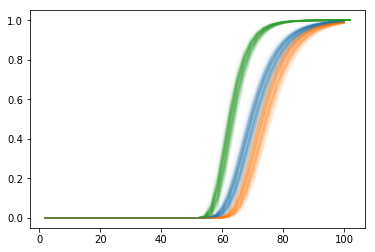

In [10]:
## plot all the TCP curves
for i in range(100):
    plt.plot(p_machine[i]['nom_doses'],p_machine[i]['TCP_pop'],c=color_p,alpha=0.05)
    plt.plot(hn_machine[i]['nom_doses'],hn_machine[i]['TCP_pop'],c=color_hn,alpha=0.05)
    plt.plot(fc_machine[i]['nom_doses'],fc_machine[i]['TCP_pop'],c=color_fc,alpha=0.05)

plt.show()

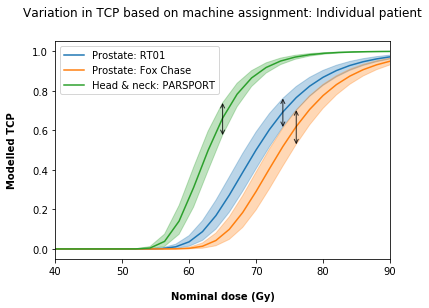

0.61649542962 0.761234699576
0.528730033617 0.70193838877
0.575479704976 0.73863172246
6.43125797875
8.60875532721
7.59232842296


In [11]:
p_tcps = [p_machine[i]['TCP_pop'] for i in range(len(p_machine))]
p_nom_d = p_machine[0]['nom_doses']
p_tcp_mean = np.mean(p_tcps,axis=0)
p_tcp_sd = np.std(p_tcps,axis=0)
p_tcp_5 = np.percentile(p_tcps,5,axis=0)
p_tcp_95 = np.percentile(p_tcps,95,axis=0)

fc_tcps = [fc_machine[i]['TCP_pop'] for i in range(len(fc_machine))]
fc_nom_d = fc_machine[0]['nom_doses']
fc_tcp_mean = np.mean(fc_tcps,axis=0)
fc_tcp_sd = np.std(fc_tcps,axis=0)
fc_tcp_5 = np.percentile(fc_tcps,5,axis=0)
fc_tcp_95 = np.percentile(fc_tcps,95,axis=0)

hn_tcps = [hn_machine[i]['TCP_pop'] for i in range(len(hn_machine))]
hn_nom_d = hn_machine[0]['nom_doses']
hn_tcp_mean = np.mean(hn_tcps,axis=0)
hn_tcp_sd = np.std(hn_tcps,axis=0)
hn_tcp_5 = np.percentile(hn_tcps,5,axis=0)
hn_tcp_95 = np.percentile(hn_tcps,95,axis=0)

plt.plot(p_nom_d,p_tcp_mean,label='Prostate: RT01',c=color_p)
#plt.plot(p_nom_d,p_tcp_5)
#plt.plot(p_nom_d,p_tcp_95)
plt.fill_between(p_nom_d,p_tcp_5,p_tcp_95,color=color_p,zorder=0,alpha=0.3)

plt.plot(fc_nom_d,fc_tcp_mean,label='Prostate: Fox Chase',c=color_fc)
#plt.plot(fc_nom_d,fc_tcp_5)
#plt.plot(fc_nom_d,fc_tcp_95)
plt.fill_between(fc_nom_d,fc_tcp_5,fc_tcp_95,color=color_fc,zorder=0,alpha=0.3)

plt.plot(hn_nom_d,hn_tcp_mean,label='Head & neck: PARSPORT',c=color_hn)
#plt.plot(hn_nom_d,hn_tcp_5)
#plt.plot(hn_nom_d,hn_tcp_95)
plt.fill_between(hn_nom_d,hn_tcp_5,hn_tcp_95,color=color_hn,zorder=0,alpha=0.3)

plt.xlim(40,90)

plt.xlabel('Nominal dose (Gy)')
plt.ylabel('Modelled TCP')
plt.title('Variation in TCP based on machine assignment: Individual patient')

## show range of interest with arrows
## use annotate with no text as it seems easier
plt.annotate(s='', xy=(74,p_tcp_5[36]), xytext=(74,p_tcp_95[36]),
             arrowprops=dict(arrowstyle='<->',
                             shrinkA=0, shrinkB=0,
                             alpha=0.8))

plt.annotate(s='', xy=(76,fc_tcp_5[37]), xytext=(76,fc_tcp_95[37]),
             arrowprops=dict(arrowstyle='<->',
                             shrinkA=0, shrinkB=0,
                             alpha=0.8))

plt.annotate(s='', xy=(65,hn_tcp_5[29]), xytext=(65,hn_tcp_95[29]),
             arrowprops=dict(arrowstyle='<->',
                             shrinkA=0, shrinkB=0,
                             alpha=0.8))

plt.legend()

#plt.savefig('tcp_95CI-p+fc+hn.png',dpi=300,bbox_inches='tight')

plt.show()

## numerical results

print(p_tcp_5[36],p_tcp_95[36])
print(fc_tcp_5[37],fc_tcp_95[37])
print(hn_tcp_5[29],hn_tcp_95[29])
print(100*p_tcp_sd[36]/p_tcp_mean[36]) ## SD in perc at dose of interest
print(100*fc_tcp_sd[37]/fc_tcp_mean[37]) ## SD in perc at dose of interest
print(100*hn_tcp_sd[29]/hn_tcp_mean[29]) ## SD in perc at dose of interest

In [12]:
## now repat the above for a population - plot the variaiton in means as above
## this will have shallower gradients for RT01.

## generate 100(0) random dose deviaitons from normal distribution
the_n = 1000
the_sd = 1.0
the_mean = 0
dose_shifts = np.random.normal(loc=the_mean,scale=the_sd,size=the_n)

## generate p + HN results for each of these dose shifts adn save the results

p_res_pop = []
hn_res_pop = []
fc_res_pop = []

do_this = True
if do_this == True:
    i=1
    for the_d in dose_shifts:
        if i % 10 == 0:
            print(i, 'of',the_n)
        i=i+1

        p_results = model.completeTCPcalc(n=1000,                  # number of patients in population to model
                                          alphabeta_use=2,      # mean alpha/beta
                                          alphabeta_sd_use=100,     # SD of alpha/beta (%)
                                          d=2,                    # nominal dose (Gy/fraction)
                                          d_shift=the_d,          # initial dose difference (%)
                                          d_sd=0,                 # standard deviation of delivered dose (%)
                                          d_trend=0,              # dose drift (%/day)
                                          max_d=100,              # maximum dose for which TCP is calcualted (Gy)
                                          dose_of_interest=74,    # results of TCP at this dose are returned seperately for simpler analysis.
                                          n0 = 1E4,
                                         set_beta=0.04) 

        fc_results = model.completeTCPcalc(n=1000,                  # number of patients in population to model
                                          alphabeta_use=2,      # mean alpha/beta
                                          alphabeta_sd_use=5,     # SD of alpha/beta (%)
                                          d=2,                    # nominal dose (Gy/fraction)
                                          d_shift=the_d,          # initial dose difference (%)
                                          d_sd=0,                 # standard deviation of delivered dose (%)
                                          d_trend=0,              # dose drift (%/day)
                                          max_d=100,              # maximum dose for which TCP is calcualted (Gy)
                                          dose_of_interest=76,    # results of TCP at this dose are returned seperately for simpler analysis.
                                          n0 = 5E4,
                                         set_beta=0.04) 

        hn_results = model.completeTCPcalc(n=1000,                  # number of patients in population to model
                                          alphabeta_use=10,      # mean alpha/beta
                                          alphabeta_sd_use=25,     # SD of alpha/beta (%)
                                          d=65/30,                    # nominal dose (Gy/fraction)
                                          d_shift=the_d,          # initial dose difference (%)
                                          d_sd=0,                 # standard deviation of delivered dose (%)
                                          d_trend=0,              # dose drift (%/day)
                                          max_d=100,              # maximum dose for which TCP is calcualted (Gy)
                                          dose_of_interest=65,    # results of TCP at this dose are returned seperately for simpler analysis.
                                          n0 = 1E6,
                                          set_beta=0.02)                # N0 as determnined through population fit

        ## only saving the pop TCP to save on memory (had memory issues on PC so wouldn't complete) - same dict format to keep following code the same
        ## originally just p_res_pop.append(p_results)
        p_res_pop.append({'TCP_pop':p_results['TCP_pop'],'nom_doses':p_results['nom_doses']})
        hn_res_pop.append({'TCP_pop':hn_results['TCP_pop'],'nom_doses':hn_results['nom_doses']})
        fc_res_pop.append({'TCP_pop':fc_results['TCP_pop'],'nom_doses':fc_results['nom_doses']})



10 of 1000
20 of 1000
30 of 1000
40 of 1000
50 of 1000
60 of 1000
70 of 1000
80 of 1000
90 of 1000
100 of 1000
110 of 1000
120 of 1000
130 of 1000
140 of 1000
150 of 1000
160 of 1000
170 of 1000
180 of 1000
190 of 1000
200 of 1000
210 of 1000
220 of 1000
230 of 1000
240 of 1000
250 of 1000
260 of 1000
270 of 1000
280 of 1000
290 of 1000
300 of 1000
310 of 1000
320 of 1000
330 of 1000
340 of 1000
350 of 1000
360 of 1000
370 of 1000
380 of 1000
390 of 1000
400 of 1000
410 of 1000
420 of 1000
430 of 1000
440 of 1000
450 of 1000
460 of 1000
470 of 1000
480 of 1000
490 of 1000
500 of 1000
510 of 1000
520 of 1000
530 of 1000
540 of 1000
550 of 1000
560 of 1000
570 of 1000
580 of 1000
590 of 1000
600 of 1000
610 of 1000
620 of 1000
630 of 1000
640 of 1000
650 of 1000
660 of 1000
670 of 1000
680 of 1000
690 of 1000
700 of 1000
710 of 1000
720 of 1000
730 of 1000
740 of 1000
750 of 1000
760 of 1000
770 of 1000
780 of 1000
790 of 1000
800 of 1000
810 of 1000
820 of 1000
830 of 1000
840 of 1000
8

In [13]:
##set variables
p_machine_pop = p_res_pop
hn_machine_pop = hn_res_pop
fc_machine_pop = fc_res_pop


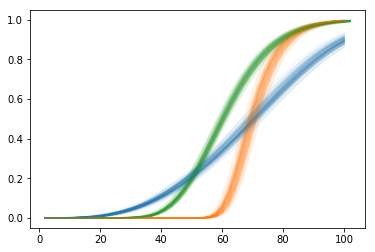

In [14]:
## plot all the TCP curves
for i in range(100):
    plt.plot(p_machine_pop[i]['nom_doses'],p_machine_pop[i]['TCP_pop'],c=color_p,alpha=0.05)
    plt.plot(hn_machine_pop[i]['nom_doses'],hn_machine_pop[i]['TCP_pop'],c=color_hn,alpha=0.05)
    plt.plot(fc_machine_pop[i]['nom_doses'],fc_machine_pop[i]['TCP_pop'],c=color_fc,alpha=0.05)

plt.show()

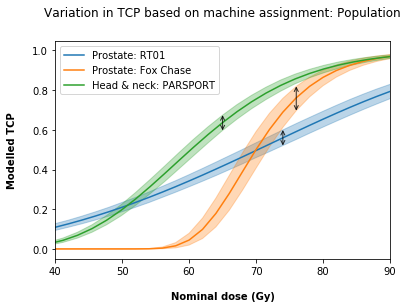

0.520773040403 0.599361507048
0.6965313126 0.818770918362
0.597002870582 0.674005694914
4.19434946963
4.98267502492
3.69860770059


In [15]:
p_tcps = [p_machine_pop[i]['TCP_pop'] for i in range(len(p_machine_pop))]
p_nom_d = p_machine_pop[0]['nom_doses']
p_tcp_mean = np.mean(p_tcps,axis=0)
p_tcp_sd = np.std(p_tcps,axis=0)
p_tcp_5 = np.percentile(p_tcps,5,axis=0)
p_tcp_95 = np.percentile(p_tcps,95,axis=0)

fc_tcps = [fc_machine_pop[i]['TCP_pop'] for i in range(len(fc_machine_pop))]
fc_nom_d = fc_machine_pop[0]['nom_doses']
fc_tcp_mean = np.mean(fc_tcps,axis=0)
fc_tcp_sd = np.std(fc_tcps,axis=0)
fc_tcp_5 = np.percentile(fc_tcps,5,axis=0)
fc_tcp_95 = np.percentile(fc_tcps,95,axis=0)

hn_tcps = [hn_machine_pop[i]['TCP_pop'] for i in range(len(hn_machine_pop))]
hn_nom_d = hn_machine_pop[0]['nom_doses']
hn_tcp_mean = np.mean(hn_tcps,axis=0)
hn_tcp_sd = np.std(hn_tcps,axis=0)
hn_tcp_5 = np.percentile(hn_tcps,5,axis=0)
hn_tcp_95 = np.percentile(hn_tcps,95,axis=0)

plt.plot(p_nom_d,p_tcp_mean,label='Prostate: RT01',c=color_p)
#plt.plot(p_nom_d,p_tcp_5)
#plt.plot(p_nom_d,p_tcp_95)
plt.fill_between(p_nom_d,p_tcp_5,p_tcp_95,color=color_p,zorder=0,alpha=0.3)

plt.plot(fc_nom_d,fc_tcp_mean,label='Prostate: Fox Chase',c=color_fc)
#plt.plot(fc_nom_d,fc_tcp_5)
#plt.plot(fc_nom_d,fc_tcp_95)
plt.fill_between(fc_nom_d,fc_tcp_5,fc_tcp_95,color=color_fc,zorder=0,alpha=0.3)

plt.plot(hn_nom_d,hn_tcp_mean,label='Head & neck: PARSPORT',c=color_hn)
#plt.plot(hn_nom_d,hn_tcp_5)
#plt.plot(hn_nom_d,hn_tcp_95)
plt.fill_between(hn_nom_d,hn_tcp_5,hn_tcp_95,color=color_hn,zorder=0,alpha=0.3)

plt.xlim(40,90)

plt.xlabel('Nominal dose (Gy)')
plt.ylabel('Modelled TCP')
plt.title('Variation in TCP based on machine assignment: Population')

## show range of interest with arrows
## use annotate with no text as it seems easier
plt.annotate(s='', xy=(74,p_tcp_5[36]), xytext=(74,p_tcp_95[36]),
             arrowprops=dict(arrowstyle='<->',
                             shrinkA=0, shrinkB=0,
                             alpha=0.8))

plt.annotate(s='', xy=(76,fc_tcp_5[37]), xytext=(76,fc_tcp_95[37]),
             arrowprops=dict(arrowstyle='<->',
                             shrinkA=0, shrinkB=0,
                             alpha=0.8))

plt.annotate(s='', xy=(65,hn_tcp_5[29]), xytext=(65,hn_tcp_95[29]),
             arrowprops=dict(arrowstyle='<->',
                             shrinkA=0, shrinkB=0,
                             alpha=0.8))

plt.legend()

plt.savefig('tcp_95CI-p+fc+hn-pop_1perc.png',dpi=300,bbox_inches='tight')

plt.show()

## numerical results

print(p_tcp_5[36],p_tcp_95[36])
print(fc_tcp_5[37],fc_tcp_95[37])
print(hn_tcp_5[29],hn_tcp_95[29])
print(100*p_tcp_sd[36]/p_tcp_mean[36]) ## SD in perc at dose of interest
print(100*fc_tcp_sd[37]/fc_tcp_mean[37]) ## SD in perc at dose of interest
print(100*hn_tcp_sd[29]/hn_tcp_mean[29]) ## SD in perc at dose of interest

6.43125797875
8.60875532721
7.59232842296
4.19434946963
4.98267502492
3.69860770059


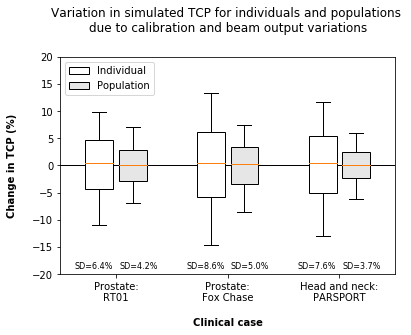

In [18]:
## produce boxplots of all individual and population results from above.
## present results as a percentage deviation from the mean.

## get just the results into a list for ease.

## individual TCPs at desired nominal dose.
p_ind = [tcp['TCP_cure_percent'] for tcp in p_res]
fc_ind = [tcp['TCP_cure_percent'] for tcp in fc_res]
hn_ind = [tcp['TCP_cure_percent'] for tcp in hn_res]

## pop TCPs at desired nominal dose - only 'TCP_pop' and 'nom_doses' to work with
## so have to extract correct point from TPC curve
p_pop = [tcp['TCP_pop'][36] for tcp in p_res_pop]
fc_pop = [tcp['TCP_pop'][37] for tcp in fc_res_pop]
hn_pop = [tcp['TCP_pop'][29] for tcp in hn_res_pop]

## now get each as a percentage difference from the mean

p_ind_perc = [((tcp/np.mean(p_ind))-1)*100 for tcp in p_ind]
fc_ind_perc = [((tcp/np.mean(fc_ind))-1)*100 for tcp in fc_ind]
hn_ind_perc = [((tcp/np.mean(hn_ind))-1)*100 for tcp in hn_ind]
p_pop_perc = [((tcp/np.mean(p_pop))-1)*100 for tcp in p_pop]
fc_pop_perc = [((tcp/np.mean(fc_pop))-1)*100 for tcp in fc_pop]
hn_pop_perc = [((tcp/np.mean(hn_pop))-1)*100 for tcp in hn_pop]

## create boxplot
## store individual and population data in 2 lists
ind_data = [p_ind_perc,fc_ind_perc,hn_ind_perc]
pop_data = [p_pop_perc,fc_pop_perc,hn_pop_perc]

## combined plot - uses ax. so can get auto legend from colour of boxplots
#plt.boxplot(ind_data,whis=[5,95],showfliers=False)
#plt.boxplot(pop_data,whis=[5,95],showfliers=False)
fig, ax = plt.subplots()

offset = 0.15
width = 0.25
## left
bp1 = ax.boxplot(ind_data,vert=True,widths=width,whis=[5,95],sym='',showmeans=False,
            positions=[1-offset,2-offset,3-offset], patch_artist=True,boxprops={'facecolor':'white','alpha':1})
## right
bp2 = ax.boxplot(pop_data,vert=True,widths=width,whis=[5,95],sym='',showmeans=False,
           positions=[1+offset,2+offset,3+offset], patch_artist=True,boxprops={'facecolor':'#E6E6E6','alpha':1,'edgecolor':'black'})

plt.xticks([1,2,3],['Prostate:\nRT01', 'Prostate:\nFox Chase','Head and neck:\nPARSPORT'])
plt.xlim(0.5,3.5)

ax.legend([bp1["boxes"][0], bp2["boxes"][0]], ['Individual', 'Population'],loc='upper left')

plt.axhline(0,color='black',lw=1,ls='-')
plt.ylim(-20,20)

ax.set_ylabel('Change in TCP (%)')
ax.set_xlabel('Clinical case')
plt.title('Variation in simulated TCP for individuals and populations \ndue to calibration and beam output variations')

## add text with the SDs of each onto the plot
sd_vals = []

for i in [ind_data,pop_data]:
    for j in i:
        print(np.std(j))
        sd_vals.append(np.std(j))
        
text_x = [0.8,1.8,2.8,1.2,2.2,3.2] ## manually set

for i in range(len(text_x)):
    plt.text(text_x[i],-19,'SD='+str(round(sd_vals[i],1))+'%',horizontalalignment='center',fontsize=8)

#plt.savefig('TCP_var_boxplot-corr.png',dpi=300,bbox_inches='tight')
plt.show()

In [ ]:
## compare different SDs and impact on these.

In [3]:
## repeat the above with a number of different values for SD.

test_sds = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0,1.1,1.2,1.3,1.4]

## do the below for each of the above SDs

## generate 1000 random dose deviaitons from normal distribution
the_n = 1000
the_sd = 0.8
the_mean = 0

sd_res = {}

for the_sd in test_sds:
    dose_shifts = np.random.normal(loc=the_mean,scale=the_sd,size=the_n)

    ## generate p + HN results for each of these dose shifts adn save the results

    p_res = []
    hn_res = []

    do_this = True
    if do_this == True:

        for the_d in dose_shifts:

            p_results = model.completeTCPcalc(n=1,                  # number of patients in population to model
                                              alphabeta_use=1.5,      # mean alpha/beta
                                              alphabeta_sd_use=0,     # SD of alpha/beta (%)
                                              d=2,                    # nominal dose (Gy/fraction)
                                              d_shift=the_d,          # initial dose difference (%)
                                              d_sd=0,                 # standard deviation of delivered dose (%)
                                              d_trend=0,              # dose drift (%/day)
                                              max_d=100,              # maximum dose for which TCP is calcualted (Gy)
                                              dose_of_interest=74,    # results of TCP at this dose are returned seperately for simpler analysis.
                                              n0 = 74) 


            hn_results = model.completeTCPcalc(n=1,                  # number of patients in population to model
                                              alphabeta_use=10,      # mean alpha/beta
                                              alphabeta_sd_use=0,     # SD of alpha/beta (%)
                                              d=65/30,                    # nominal dose (Gy/fraction)
                                              d_shift=the_d,          # initial dose difference (%)
                                              d_sd=0,                 # standard deviation of delivered dose (%)
                                              d_trend=0,              # dose drift (%/day)
                                              max_d=100,              # maximum dose for which TCP is calcualted (Gy)
                                              dose_of_interest=65,    # results of TCP at this dose are returned seperately for simpler analysis.
                                              n0 = 3000000)                # N0 as determnined through population fit

            p_res.append(p_results)
            hn_res.append(hn_results)
    
    sd_res[the_sd] = {'p':p_res,
                     'hn':hn_res}
    print(the_sd)


0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
1.0
1.1
1.2
1.3
1.4


In [14]:
np.std([sd_res[0.8]['hn'][i]['TCP_cure_percent'] for i in sd_res[0.8]['hn']])

TypeError: list indices must be integers or slices, not dict

In [ ]:
#save_pkl(sd_res,'sd_var_results.pkl')
sd_res = load_pkl('sd_var_results.pkl')

In [4]:
sd_res[0.2]['hn'][0]['TCP_cure_percent']

99.985289046739766

In [ ]:
all_sd_p = []
all_sd_hn = []

for sd in test_sds:
    all_tcp_p = []
    all_tcp_hn = []
    for i in range(1000):
        all_tcp_p.append(sd_res[sd]['p'][i]['TCP_cure_percent'])
        all_tcp_hn.append(sd_res[sd]['hn'][i]['TCP_cure_percent'])
    sd_p = np.std(all_tcp_p)
    sd_hn = np.std(all_tcp_hn)
    print(sd,'prost',sd_p,'hn',sd_hn)
    all_sd_p.append(sd_p)
    all_sd_hn.append(sd_hn)

plt.plot(test_sds,all_sd_p,'o',label='Prostate')
plt.plot(test_sds,all_sd_hn,'o',label='Head and neck')
plt.legend()
plt.xlabel('Beam calibration standard deviation (%)')
plt.ylabel('TCP standard deviation (%)')
plt.title('Varaition of TCP standard deviation with dose deviation')
#plt.savefig('TCP_sd_var_with_mean_dose_var.png',dpi=300,bbox_inches='tight')
plt.show()

# Variation in dose due to daily variations only.
- Vary the d_sd value from 0 to ~3%
- The mean will stay the same, but now there will be a variation around this.
- Use a population of 1000 patients...?
- Plot whole TCP curve and table of stats


In [113]:
d_sds = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0] ## check range required.
d_sds = np.linspace(start = 0,stop = 2,num = 21,endpoint=True)

p_sd_res = {}
fc_sd_res = {}
hn_sd_res = {}

for the_d in d_sds:

    p_results = model.completeTCPcalc(n=1000,                  # number of patients in population to model
                                      alphabeta_use=2,      # mean alpha/beta
                                      alphabeta_sd_use=0,     # SD of alpha/beta (%)
                                      d=2,                    # nominal dose (Gy/fraction)
                                      d_shift=0,          # initial dose difference (%)
                                      d_sd=the_d,                 # standard deviation of delivered dose (%)
                                      d_trend=0,              # dose drift (%/day)
                                      max_d=100,              # maximum dose for which TCP is calcualted (Gy)
                                      dose_of_interest=74,    # results of TCP at this dose are returned seperately for simpler analysis.
                                      n0 = 5E4,
                                      set_beta=0.04) 

    fc_results = model.completeTCPcalc(n=1000,                  # number of patients in population to model
                                      alphabeta_use=2,      # mean alpha/beta
                                      alphabeta_sd_use=0,     # SD of alpha/beta (%)
                                      d=2,                    # nominal dose (Gy/fraction)
                                      d_shift=0,          # initial dose difference (%)
                                      d_sd=the_d,                 # standard deviation of delivered dose (%)
                                      d_trend=0,              # dose drift (%/day)
                                      max_d=100,              # maximum dose for which TCP is calcualted (Gy)
                                      dose_of_interest=76,    # results of TCP at this dose are returned seperately for simpler analysis.
                                      n0 = 9E4,
                                      set_beta=0.04) 
    
    
    hn_results = model.completeTCPcalc(n=1000,                  # number of patients in population to model
                                      alphabeta_use=10,      # mean alpha/beta
                                      alphabeta_sd_use=0,     # SD of alpha/beta (%)
                                      d=65/30,                    # nominal dose (Gy/fraction)
                                      d_shift=0,          # initial dose difference (%)
                                      d_sd=the_d,                 # standard deviation of delivered dose (%)
                                      d_trend=0,              # dose drift (%/day)
                                      max_d=100,              # maximum dose for which TCP is calcualted (Gy)
                                      dose_of_interest=65,    # results of TCP at this dose are returned seperately for simpler analysis.
                                      n0 = 3E6,
                                      set_beta=0.02)                # N0 as determnined through population fit

    p_sd_res[the_d] = p_results
    fc_sd_res[the_d] = fc_results
    hn_sd_res[the_d] = hn_results
    print(the_d)

0.0
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
1.0
1.1
1.2
1.3
1.4
1.5
1.6
1.7
1.8
1.9
2.0


In [114]:
#save_pkl(p_sd_res,'daily_dose_sd_var_p.pkl')
#save_pkl(hn_sd_res,'daily_dose_sd_var_hn.pkl')
#p_sd_res = load_pkl('daily_dose_sd_var_p.pkl')
#hn_sd_res = load_pkl('daily_dose_sd_var_hn.pkl')

sd: 0.0 p: 0.0 fc: 0.0 hn: 0.0
sd: 0.1 p: 0.1 fc: 0.08 hn: 0.14
sd: 0.2 p: 0.21 fc: 0.16 hn: 0.28
sd: 0.3 p: 0.32 fc: 0.23 hn: 0.44
sd: 0.4 p: 0.41 fc: 0.31 hn: 0.55
sd: 0.5 p: 0.53 fc: 0.39 hn: 0.71
sd: 0.6 p: 0.63 fc: 0.47 hn: 0.84
sd: 0.7 p: 0.75 fc: 0.55 hn: 0.94
sd: 0.8 p: 0.85 fc: 0.62 hn: 1.1
sd: 0.9 p: 0.96 fc: 0.71 hn: 1.24
sd: 1.0 p: 1.05 fc: 0.78 hn: 1.34
sd: 1.1 p: 1.15 fc: 0.84 hn: 1.54
sd: 1.2 p: 1.28 fc: 0.94 hn: 1.65
sd: 1.3 p: 1.36 fc: 1.01 hn: 1.7
sd: 1.4 p: 1.47 fc: 1.07 hn: 1.92
sd: 1.5 p: 1.55 fc: 1.15 hn: 2.05
sd: 1.6 p: 1.73 fc: 1.27 hn: 2.23
sd: 1.7 p: 1.79 fc: 1.31 hn: 2.36
sd: 1.8 p: 1.94 fc: 1.43 hn: 2.53
sd: 1.9 p: 1.98 fc: 1.46 hn: 2.72
sd: 2.0 p: 2.17 fc: 1.59 hn: 2.82



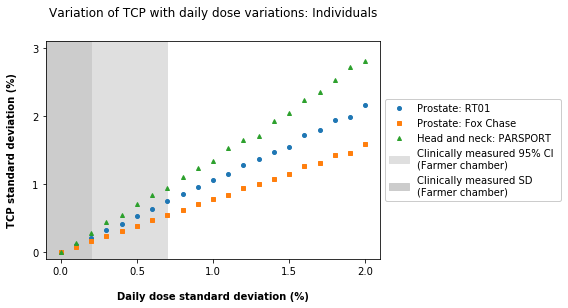

In [115]:
## now need to get teh SD of teh TCP at the required dose ([36] or [29])

the_sds = list(p_sd_res.keys())

all_sd_perc = {}


for the_sd in the_sds:

    ## get array of all TCP vals and use numpy to get sd from column
    p_tcp_vals = p_sd_res[the_sd]['TCPs']
    fc_tcp_vals = fc_sd_res[the_sd]['TCPs']
    hn_tcp_vals = hn_sd_res[the_sd]['TCPs']

    p_tcp_sd = np.std(p_tcp_vals,axis=0) ## absolute SD
    fc_tcp_sd = np.std(fc_tcp_vals,axis=0) ## absolute SD
    hn_tcp_sd = np.std(hn_tcp_vals,axis=0) ## absolute SD

    p_tcp_mean = np.mean(p_tcp_vals,axis=0)
    fc_tcp_mean = np.mean(fc_tcp_vals,axis=0)
    hn_tcp_mean = np.mean(hn_tcp_vals,axis=0)

    ## convert to percentage
    p_tcp_sd_perc = 100*p_tcp_sd/p_tcp_mean
    fc_tcp_sd_perc = 100*fc_tcp_sd/p_tcp_mean
    hn_tcp_sd_perc = 100*hn_tcp_sd/hn_tcp_mean
    
    ## store the data at dose of interest
    all_sd_perc[the_sd] = {'p':p_tcp_sd_perc[36],
                           'fc':p_tcp_sd_perc[37],
                          'hn':hn_tcp_sd_perc[29]}


## create plot of TCP sds vs dose sds
p_sds = []
fc_sds = []
hn_sds = []
plot_sds = []

for i in sorted(all_sd_perc):
    plot_sds.append(i)
    p_sds.append(all_sd_perc[i]['p'])
    fc_sds.append(all_sd_perc[i]['fc'])
    hn_sds.append(all_sd_perc[i]['hn'])
    print('sd:',i,'p:',round(all_sd_perc[i]['p'],2),'fc:',round(all_sd_perc[i]['fc'],2),'hn:',round(all_sd_perc[i]['hn'],2))

print('')

do_plot = True

if do_plot == True:
    plt.plot(plot_sds,p_sds,marker=marker_p,color=color_p,label='Prostate: RT01',ms=4,ls='')
    plt.plot(plot_sds,fc_sds,marker=marker_fc,color=color_fc,label='Prostate: Fox Chase',ms=4,ls='')
    plt.plot(plot_sds,hn_sds,marker=marker_hn,color=color_hn,label='Head and neck: PARSPORT',ms=4,ls='')

    plt.title('Variation of TCP with daily dose variations: Individuals')
    plt.xlabel('Daily dose standard deviation (%)')
    plt.ylabel('TCP standard deviation (%)')

    plt.xticks([0,0.5,1,1.5,2])
    plt.yticks([0,1,2,3])
    plt.ylim(-0.1,3.1)

    ## shading

    plt.axvspan(-1,0.7,alpha=1,color='#dfdfdf',zorder=0,label='Clinically measured 95% CI \n(Farmer chamber)')
    plt.axvspan(-1,0.2,alpha=1,color='#cccccc',zorder=0,label='Clinically measured SD \n(Farmer chamber)')
    plt.xlim(-0.1,2.1)
    #plt.ylim(None,4)

    leg = plt.legend(loc='center left', bbox_to_anchor=(1, 0.5),fontsize=10)
    leg.get_frame().set_alpha(1)

    #plt.savefig('TCP_var_with_daily_sd_var.png',dpi=300,bbox_inches='tight')
    plt.show()


In [107]:
## generate some a/b values for 100 patients

## this returns a and b values seperately, so convert resutls into a list of a/b values to feed to model.

pop_size = 1000 ## population size for each run
repeats = 100 ## repeat modelling at each dose SD
sds = [0,0.2,0.4,0.6,0.8,1.0,1.5,2.0] ## dose SDs
sds = np.linspace(start = 0,stop = 2,num = 21,endpoint=True)

p_ab = model.completeTCPcalc(n=pop_size,                  # number of patients in population to model
                                   alphabeta_use=2,      # mean alpha/beta
                                   alphabeta_sd_use=100,     # SD of alpha/beta (%)
                                   d=2,                    # nominal dose (Gy/fraction)
                                   d_shift=0,          # initial dose difference (%)
                                   d_sd=0,                 # standard deviation of delivered dose (%)
                                   d_trend=0,              # dose drift (%/day)
                                   max_d=100,              # maximum dose for which TCP is calcualted (Gy)
                                   dose_of_interest=74,    # results of TCP at this dose are returned seperately for simpler analysis.
                                   n0 = 1E4,
                                   set_beta=0.04)['alpha_and_beta']

fc_ab = model.completeTCPcalc(n=pop_size,                  # number of patients in population to model
                                  alphabeta_use=2,      # mean alpha/beta
                                  alphabeta_sd_use=5,     # SD of alpha/beta (%)
                                  d=2,                    # nominal dose (Gy/fraction)
                                  d_shift=0,          # initial dose difference (%)
                                  d_sd=0,                 # standard deviation of delivered dose (%)
                                  d_trend=0,              # dose drift (%/day)
                                  max_d=100,              # maximum dose for which TCP is calcualted (Gy)
                                  dose_of_interest=76,    # results of TCP at this dose are returned seperately for simpler analysis.
                                  n0 = 5E4,
                                  set_beta=0.04)['alpha_and_beta']


hn_ab = model.completeTCPcalc(n=pop_size,                  # number of patients in population to model
                                  alphabeta_use=10,      # mean alpha/beta
                                  alphabeta_sd_use=25,     # SD of alpha/beta (%)
                                  d=65/30,                    # nominal dose (Gy/fraction)
                                  d_shift=0,          # initial dose difference (%)
                                  d_sd=0,                 # standard deviation of delivered dose (%)
                                  d_trend=0,              # dose drift (%/day)
                                  max_d=100,              # maximum dose for which TCP is calcualted (Gy)
                                  dose_of_interest=65,    # results of TCP at this dose are returned seperately for simpler analysis.
                                  n0 = 1E6,
                                  set_beta=0.02)['alpha_and_beta']     # N0 as determnined through population fit

## get list of a/b values from a and b values - use these form now on for consistency
p_ab_val = [i[0]/i[1] for i in p_ab]
fc_ab_val = [i[0]/i[1] for i in fc_ab]
hn_ab_val = [i[0]/i[1] for i in hn_ab]


## now get TCP for each patient in the population and repeat for different dose SDs

p_tcp_sds = {}
fc_tcp_sds = {}
hn_tcp_sds = {}

for the_d in sds:
    print(the_d)

    p_tcp_means = [] ## interested in the population mean TCP
    fc_tcp_means = [] ## interested in the population mean TCP
    hn_tcp_means = [] ## interested in the population mean TCP

    for j in range(repeats):
        #print(j,'of',repeats)
        p_tcps = [] ## store each patients TCP
        fc_tcps = [] ## store each patients TCP
        hn_tcps = [] ## store each patients TCP

        ## RT01
        for i in p_ab_val:
            p_tcp = model.completeTCPcalc(n=1,                  # number of patients in population to model
                                          alphabeta_use=i,      # mean alpha/beta
                                          alphabeta_sd_use=0,     # SD of alpha/beta (%)
                                          d=2,                    # nominal dose (Gy/fraction)
                                          d_shift=0,          # initial dose difference (%)
                                          d_sd=the_d,                 # standard deviation of delivered dose (%)
                                          d_trend=0,              # dose drift (%/day)
                                          max_d=100,              # maximum dose for which TCP is calcualted (Gy)
                                          dose_of_interest=74,    # results of TCP at this dose are returned seperately for simpler analysis.
                                          n0 = 1E4,
                                          set_beta=0.04)['TCP_pop'][36]     # N0 as determnined through population fit
            p_tcps.append(p_tcp)
        
        ## Fox Chase
        for i in fc_ab_val:
            fc_tcp = model.completeTCPcalc(n=1,                  # number of patients in population to model
                                          alphabeta_use=i,      # mean alpha/beta
                                          alphabeta_sd_use=0,     # SD of alpha/beta (%)
                                          d=2,                    # nominal dose (Gy/fraction)
                                          d_shift=0,          # initial dose difference (%)
                                          d_sd=the_d,                 # standard deviation of delivered dose (%)
                                          d_trend=0,              # dose drift (%/day)
                                          max_d=100,              # maximum dose for which TCP is calcualted (Gy)
                                          dose_of_interest=76,    # results of TCP at this dose are returned seperately for simpler analysis.
                                          n0 = 5E4,
                                          set_beta=0.04)['TCP_pop'][37]     # N0 as determnined through population fit
            fc_tcps.append(fc_tcp)

        ## H&N
        for i in hn_ab_val:
            hn_tcp = model.completeTCPcalc(n=1,                  # number of patients in population to model
                                          alphabeta_use=i,      # mean alpha/beta
                                          alphabeta_sd_use=0,     # SD of alpha/beta (%)
                                          d=65/30,                    # nominal dose (Gy/fraction)
                                          d_shift=0,          # initial dose difference (%)
                                          d_sd=the_d,                 # standard deviation of delivered dose (%)
                                          d_trend=0,              # dose drift (%/day)
                                          max_d=100,              # maximum dose for which TCP is calcualted (Gy)
                                          dose_of_interest=65,    # results of TCP at this dose are returned seperately for simpler analysis.
                                          n0 = 1E6,
                                          set_beta=0.02)['TCP_pop'][29]     # N0 as determnined through population fit
            #print(i,hn_tcp)
            hn_tcps.append(hn_tcp)

        ## get mean TCP for this pop and store value
        p_tcp_means.append(np.mean(p_tcps))
        fc_tcp_means.append(np.mean(fc_tcps))
        hn_tcp_means.append(np.mean(hn_tcps))
        
    #print(hn_tcp_means)
    
    ## store the SD of the mean TCPs as a perc
    p_tcp_sds[the_d] = 100*np.std(p_tcp_means)/np.mean(p_tcp_means)
    fc_tcp_sds[the_d] = 100*np.std(fc_tcp_means)/np.mean(fc_tcp_means)
    hn_tcp_sds[the_d] = 100*np.std(hn_tcp_means)/np.mean(hn_tcp_means)

0.0
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
1.0
1.1
1.2
1.3
1.4
1.5
1.6
1.7
1.8
1.9
2.0


In [108]:
for i in sds:
    print(i,p_tcp_sds[i],fc_tcp_sds[i],hn_tcp_sds[i])

0.0 0.0 1.452977724e-14 0.0
0.1 0.00248026159811 0.00263033148152 0.00274161658025
0.2 0.00500482994452 0.00494605717777 0.00544476129611
0.3 0.00712198954809 0.00758041726887 0.00798183843757
0.4 0.0103160514429 0.0100474958153 0.0109931761747
0.5 0.0128091238536 0.0141697872596 0.0135764283195
0.6 0.0165698684484 0.0156115000352 0.0158070739306
0.7 0.0192247223367 0.0166972252815 0.0186974129598
0.8 0.0215389870344 0.0204279017119 0.0205594725741
0.9 0.0239505578555 0.0208066212017 0.0261995677366
1.0 0.0294233085034 0.0271350045534 0.0241403228491
1.1 0.0293746118931 0.0275516282667 0.0279624295132
1.2 0.0287826848258 0.0327922843383 0.0311083985299
1.3 0.0322682165456 0.0318499064048 0.0360194929286
1.4 0.0322845880023 0.034898933649 0.0402325313282
1.5 0.0370572001357 0.0384956386126 0.0435750695463
1.6 0.0405079389328 0.0473139080328 0.0471736640334
1.7 0.040366196168 0.0394264107652 0.0453439989805
1.8 0.0485797770364 0.0481802399521 0.043181276243
1.9 0.045833498689 0.053160302

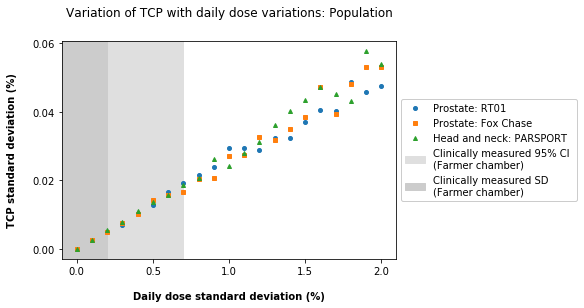

In [112]:
## get all values to plot into lists for ease

plot_sds = sorted([i for i in hn_tcp_sds])
p_sds = [p_tcp_sds[i] for i in plot_sds]
fc_sds = [fc_tcp_sds[i] for i in plot_sds]
hn_sds = [hn_tcp_sds[i] for i in plot_sds]

## normalise to the variation from zero SD result - will allow all to be plotted more clearly
#p_sds_norm = [((p_sds[i]/p_sds[0])-1)*100 for i in range(len(plot_sds))]
#fc_sds_norm = [((fc_sds[i]/fc_sds[0])-1)*100 for i in range(len(plot_sds))]
#hn_sds_norm = [((hn_sds[i]/hn_sds[0])-1)*100 for i in range(len(plot_sds))]

## plot the results
plt.plot(plot_sds,p_sds,marker=marker_p,color=color_p,label='Prostate: RT01',ms=4,ls='')
plt.plot(plot_sds,fc_sds,marker=marker_fc,color=color_fc,label='Prostate: Fox Chase',ms=4,ls='')
plt.plot(plot_sds,hn_sds,marker=marker_hn,color=color_hn,label='Head and neck: PARSPORT',ms=4,ls='')

plt.title('Variation of TCP with daily dose variations: Population')
plt.xlabel('Daily dose standard deviation (%)')
plt.ylabel('TCP standard deviation (%)')

plt.xticks([0,0.5,1,1.5,2])
plt.yticks([0,0.02,0.04,0.06])
#plt.ylim(-0.1,3.1)

## shading

plt.axvspan(-1,0.7,alpha=1,color='#dfdfdf',zorder=0,label='Clinically measured 95% CI \n(Farmer chamber)')
plt.axvspan(-1,0.2,alpha=1,color='#cccccc',zorder=0,label='Clinically measured SD \n(Farmer chamber)')
plt.xlim(-0.1,2.1)
#plt.ylim(None,4)

leg = plt.legend(loc='center left', bbox_to_anchor=(1, 0.5),fontsize=10)
leg.get_frame().set_alpha(1)

#plt.savefig('TCP_var_with_daily_sd_var-pop.png',dpi=300,bbox_inches='tight')
plt.show()

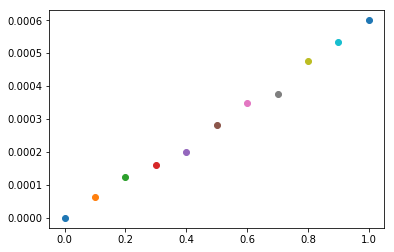

In [60]:
for i in sorted(hn_tcp_sds):
    plt.plot(i,hn_tcp_sds[i],'o')
plt.show()

In [18]:
## as above for population

#d_sds = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0] ## check range required.
d_sds = [0,0.5,1,2]
#d_sds = np.linspace(start = 0,stop = 2,num = 21,endpoint=True)

p_sd_res_pop = {}
fc_sd_res_pop = {}
hn_sd_res_pop = {}

## need to do 1000 pateints 1000 times... i.e get pop_TCP 1000 timnes!


repeats = 1000 ## number of times to repeat pop results?
pop_size = 1000

## might have to fix the a/b ratios used to eliminate the variation between runs?
## so this would then show only the variaiotn due to dose SD and remove the impact of dif patietns being selected.
## does the model allow this?
## might have to do manually - model 1 patient with fixed a/b ratios and tehn combine to create a pop 

for the_d in d_sds:
    p_res_rpt = []
    fc_res_rpt = []
    hn_res_rpt = []
    
    print('dose sd:',the_d)
    
    for i in range(repeats):
        #print(i,'of',repeats,'repeats') ## calculate pop_tcp multiple times
        if i % 50 == 0:
            print(i, 'of',repeats)

        ## calcualte pop_tcp
        p_results = model.completeTCPcalc(n=pop_size,                  # number of patients in population to model
                                          alphabeta_use=2,      # mean alpha/beta
                                          alphabeta_sd_use=100,     # SD of alpha/beta (%)
                                          d=2,                    # nominal dose (Gy/fraction)
                                          d_shift=0,          # initial dose difference (%)
                                          d_sd=the_d,                 # standard deviation of delivered dose (%)
                                          d_trend=0,              # dose drift (%/day)
                                          max_d=100,              # maximum dose for which TCP is calcualted (Gy)
                                          dose_of_interest=74,    # results of TCP at this dose are returned seperately for simpler analysis.
                                          n0 = 1E4,
                                          set_beta=0.04)['TCP_pop'][36]

        fc_results = model.completeTCPcalc(n=pop_size,                  # number of patients in population to model
                                          alphabeta_use=2,      # mean alpha/beta
                                          alphabeta_sd_use=5,     # SD of alpha/beta (%)
                                          d=2,                    # nominal dose (Gy/fraction)
                                          d_shift=0,          # initial dose difference (%)
                                          d_sd=the_d,                 # standard deviation of delivered dose (%)
                                          d_trend=0,              # dose drift (%/day)
                                          max_d=100,              # maximum dose for which TCP is calcualted (Gy)
                                          dose_of_interest=76,    # results of TCP at this dose are returned seperately for simpler analysis.
                                          n0 = 5E4,
                                          set_beta=0.04)['TCP_pop'][37]


        hn_results = model.completeTCPcalc(n=pop_size,                  # number of patients in population to model
                                          alphabeta_use=10,      # mean alpha/beta
                                          alphabeta_sd_use=25,     # SD of alpha/beta (%)
                                          d=65/30,                    # nominal dose (Gy/fraction)
                                          d_shift=0,          # initial dose difference (%)
                                          d_sd=the_d,                 # standard deviation of delivered dose (%)
                                          d_trend=0,              # dose drift (%/day)
                                          max_d=100,              # maximum dose for which TCP is calcualted (Gy)
                                          dose_of_interest=65,    # results of TCP at this dose are returned seperately for simpler analysis.
                                          n0 = 1E6,
                                          set_beta=0.02)['TCP_pop'][29]                # N0 as determnined through population fit

        p_res_rpt.append(p_results)
        fc_res_rpt.append(fc_results)
        hn_res_rpt.append(hn_results)
    
    ## store all the pop_tcp values with the doseSD in a dict
    p_sd_res_pop[the_d] = p_res_rpt
    fc_sd_res_pop[the_d] = fc_res_rpt
    hn_sd_res_pop[the_d] = hn_res_rpt
    print(the_d)

dose sd: 0
0 of 1000
50 of 1000
100 of 1000
150 of 1000
200 of 1000
250 of 1000
300 of 1000
350 of 1000
400 of 1000
450 of 1000
500 of 1000
550 of 1000
600 of 1000
650 of 1000
700 of 1000
750 of 1000
800 of 1000
850 of 1000
900 of 1000
950 of 1000
0
dose sd: 0.5
0 of 1000
50 of 1000
100 of 1000
150 of 1000
200 of 1000
250 of 1000
300 of 1000
350 of 1000
400 of 1000
450 of 1000
500 of 1000
550 of 1000
600 of 1000
650 of 1000
700 of 1000
750 of 1000
800 of 1000
850 of 1000
900 of 1000


KeyboardInterrupt: 

In [17]:
## check the plot below is showing the correct value - it is :)
sd = np.std(p_sd_res_pop[2])
mean = np.mean(p_sd_res_pop[2])
sd_perc = sd/mean*100
print(mean,sd,sd_perc)

0.55579337482 0.041603692061 7.48546023501


In [53]:
#for i in p_sd_res_pop:
#    print(i,p_sd_res_pop[i])
 
print(p_sd_res_pop[1])
## so each i p_sd_res_pop has a list of TCP_pops for a given SD

[0.5905058968391359, 0.49195795125397046, 0.55994134299351617, 0.50815057510245976, 0.49326681538255363, 0.58179847820852415, 0.58552855425824735, 0.63180697602699509, 0.5785888275048372, 0.62218286603298179, 0.5517878415772558, 0.56222095441691466, 0.53632836146108431, 0.62076373084974112, 0.58225679714908019, 0.52876307775512998, 0.55028917584523296, 0.56050083086243041, 0.57853511494641163, 0.52834964434327114, 0.55003038098170021, 0.57323745429186679, 0.59531905455110579, 0.46808916769644038, 0.55615940973690459, 0.56258222371730704, 0.58254101400920766, 0.57216601762629093, 0.56720399889875484, 0.47101635553648147, 0.50438145951900548, 0.55768409180363576, 0.65972498873372176, 0.52112650336060728, 0.54519234516743675, 0.57326829547075164, 0.51470918367212748, 0.59010192886903357, 0.58078449475832683, 0.6180684293092944, 0.55098279060194999, 0.54633763664371848, 0.62806424723376031, 0.55701110281998123, 0.55481082316367525, 0.49993356003850364, 0.61463850679605503, 0.63778801814567

sd: 0 p: 6.93 fc: 1.15 hn: 6.45
sd: 0.5 p: 7.66 fc: 1.06 hn: 6.35
sd: 1 p: 8.06 fc: 0.97 hn: 5.2
sd: 2 p: 7.49 fc: 1.16 hn: 5.73



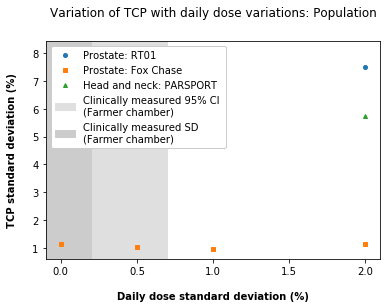

In [16]:
## now need to get teh SD of teh TCP at the required dose ([36] or [29])

the_sds = list(p_sd_res_pop.keys())

all_sd_perc = {}


for the_sd in the_sds:

    ## get array of all TCP vals and use numpy to get sd from column
    p_tcp_vals = p_sd_res_pop[the_sd]#['TCPs']
    fc_tcp_vals = fc_sd_res_pop[the_sd]#['TCPs']
    hn_tcp_vals = hn_sd_res_pop[the_sd]#['TCPs']

    p_tcp_sd = np.std(p_tcp_vals) ## absolute SD
    fc_tcp_sd = np.std(fc_tcp_vals) ## absolute SD
    hn_tcp_sd = np.std(hn_tcp_vals) ## absolute SD

    p_tcp_mean = np.mean(p_tcp_vals)
    fc_tcp_mean = np.mean(fc_tcp_vals)
    hn_tcp_mean = np.mean(hn_tcp_vals)

    ## convert to percentage
    p_tcp_sd_perc = 100*p_tcp_sd/p_tcp_mean
    fc_tcp_sd_perc = 100*fc_tcp_sd/p_tcp_mean
    hn_tcp_sd_perc = 100*hn_tcp_sd/hn_tcp_mean
    
    ## store the data at dose of interest
    all_sd_perc[the_sd] = {'p':p_tcp_sd_perc,
                           'fc':fc_tcp_sd_perc,
                          'hn':hn_tcp_sd_perc}


## create plot of TCP sds vs dose sds
p_sds = []
fc_sds = []
hn_sds = []
plot_sds = []

for i in sorted(all_sd_perc):
    plot_sds.append(i)
    p_sds.append(all_sd_perc[i]['p'])
    fc_sds.append(all_sd_perc[i]['fc'])
    hn_sds.append(all_sd_perc[i]['hn'])
    print('sd:',i,'p:',round(all_sd_perc[i]['p'],2),'fc:',round(all_sd_perc[i]['fc'],2),'hn:',round(all_sd_perc[i]['hn'],2))

print('')

do_plot = True

if do_plot == True:
    plt.plot(plot_sds,p_sds,marker=marker_p,color=color_p,label='Prostate: RT01',ms=4,ls='')
    plt.plot(plot_sds,fc_sds,marker=marker_fc,color=color_fc,label='Prostate: Fox Chase',ms=4,ls='')
    plt.plot(plot_sds,hn_sds,marker=marker_hn,color=color_hn,label='Head and neck: PARSPORT',ms=4,ls='')

    plt.title('Variation of TCP with daily dose variations: Population')
    plt.xlabel('Daily dose standard deviation (%)')
    plt.ylabel('TCP standard deviation (%)')

    plt.xticks([0,0.5,1,1.5,2])
    #plt.yticks([0,1,2,3])
    #plt.ylim(-0.1,3.1)

    ## shading

    plt.axvspan(-1,0.7,alpha=1,color='#dfdfdf',zorder=0,label='Clinically measured 95% CI \n(Farmer chamber)')
    plt.axvspan(-1,0.2,alpha=1,color='#cccccc',zorder=0,label='Clinically measured SD \n(Farmer chamber)')
    plt.xlim(-0.1,2.1)
    #plt.ylim(None,4)

    leg = plt.legend(loc='center left', bbox_to_anchor=(1, 0.5),fontsize=10)
    leg.get_frame().set_alpha(1)

    #plt.savefig('TCP_var_with_daily_sd_var.png',dpi=300,bbox_inches='tight')
    plt.show()

    
## the SD in predicted TCP is >> due to biological variation than 